# Packages 

In [3]:
import open3d as o3d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob 
import copy
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import os
import pickle as pkl
from functools import reduce


# Functions

## Convert .xls to .pcd
Note that it saves point clouds to same folder as excel files

In [4]:
def excel_to_pcd(excel_list, names_list, return_filenames = False):
    """ Save excel sheets from imaris with position information into .pcd format. 
    If return_filenames = True, return names of saved .pcd files"""
    
    filenames = []
    for index in range(len(excel_list)):
        excel_np = excel_list[index].to_numpy(dtype= "float64")
        excel_pcd=o3d.geometry.PointCloud() #Creating the PointCloud object constructor 
        excel_pcd.points=o3d.utility.Vector3dVector(excel_np)
        o3d.io.write_point_cloud(names_list[index].split('.xls')[0] + '.pcd', excel_pcd)
        filenames.append(names_list[index].split('.xls')[0] + '.pcd')
        
    if return_filenames:
        return filenames

## preprocess_point_cloud (Extract geometric features)
We down sample the point cloud, estimate normals, then compute a FPFH feature for each point. The FPFH feature is a 33-dimensional vector that describes the local geometric property of a point. A nearest neighbor query in the 33-dimensinal space can return points with similar local geometric structures. See [Rasu 2009](https://www.cvl.iis.u-tokyo.ac.jp/class2017/2017w/papers/5.3DdataProcessing/Rusu_FPFH_ICRA2009.pdf) for details.

In [5]:
def preprocess_point_cloud(pcd, voxel_size, downsampling= False, norm_radius_modifier=2,norm_maxnn=30,fpfh_radius_modifier=5,fpfh_maxnn=100):
    if downsampling:
        #print(f":: Downsample with a voxel size {voxel_size}")
        pcd_processed = pcd.voxel_down_sample(voxel_size)
    else:
        #print(":: Point Cloud was not downsampled")
        pcd_processed=pcd

    radius_normal = voxel_size * norm_radius_modifier
    #print(f":: Estimate normal with search radius {radius_normal}.")
    pcd_processed.estimate_normals(
        search_param = 
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=norm_maxnn),
    fast_normal_computation = True)

    radius_feature = voxel_size * fpfh_radius_modifier
    #print(f":: Compute FPFH feature with search radius {radius_feature}.")
    pcd_fpfh = o3d.registration.compute_fpfh_feature(
        pcd_processed,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=fpfh_maxnn))
    
    return pcd_processed, pcd_fpfh

## prepare_dataset
This function is specifically for reading in the point clouds saved by the above functions

In [6]:
def prepare_dataset(pcd_list, voxel_size, downsampling=False,norm_radius_modifier=2,norm_maxnn=30,fpfh_radius_modifier=5,fpfh_maxnn=100):
    #print(":: Load two point clouds and disturb initial pose.")
    source = o3d.io.read_point_cloud(pcd_list[0]) #sample.pcd is the source
    target = o3d.io.read_point_cloud(pcd_list[1]) #reference.pcd is the target
    source_processed, source_fpfh = preprocess_point_cloud(source, voxel_size, downsampling,norm_radius_modifier,norm_maxnn,fpfh_radius_modifier,fpfh_maxnn)
    target_processed, target_fpfh = preprocess_point_cloud(target, voxel_size, downsampling,norm_radius_modifier,norm_maxnn,fpfh_radius_modifier,fpfh_maxnn)
    return source, target, source_processed, target_processed, source_fpfh, target_fpfh

## execute_global_registration (RANSAC)

In [7]:
def execute_global_registration(source_processed, target_processed, source_fpfh,
                                target_fpfh, voxel_size, ransac_dist_modifier=1.5, ransac_edge_length=0.9):
    distance_threshold = voxel_size * ransac_dist_modifier
    """
    if downsampling:
        print(":: RANSAC registration on downsampled point clouds.")
        print("   Since the downsampling voxel size is %.3f," % voxel_size)
        print("   we use a liberal distance threshold %.3f." % distance_threshold)
    else:
        print(":: RANSAC registration on point clouds.")
        print("   Since the  voxel size is %.3f," % voxel_size)
        print("   we use a liberal distance threshold %.3f." % distance_threshold)
        
    """
        
    result = o3d.registration.registration_ransac_based_on_feature_matching(
        source_processed, target_processed, source_fpfh, target_fpfh, distance_threshold,
        o3d.registration.TransformationEstimationPointToPoint(False), 4, [
            o3d.registration.CorrespondenceCheckerBasedOnEdgeLength(ransac_edge_length),
            o3d.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.registration.RANSACConvergenceCriteria(4000000, 500))
    return result

## refine_registration (point-plane ICP)

In [8]:
def refine_registration(source, target, source_fpfh, target_fpfh, ransac_transform, voxel_size, icp_dist_check = 1):
    distance_threshold = voxel_size * icp_dist_check
    #print(":: Point-to-plane ICP registration is applied on original point")
    #print("   clouds to refine the alignment. This time we use a strict")
    #print("   distance threshold %.3f." % distance_threshold)
    result = o3d.registration.registration_icp(
        source, target, distance_threshold, ransac_transform,
        o3d.registration.TransformationEstimationPointToPlane(),
        o3d.registration.ICPConvergenceCriteria(max_iteration = 2000))
    return result

# Alignment Parameters

In [9]:
# parameters to optimize
voxel_size=10 
downsampling= False #whether or not to down sample point cloud to voxels of size "voxel_size"
norm_radius_modifier=2 #multiply by voxel size to get search radius when estimating normals
norm_maxnn=30 #maximum nearest neighbours for normal estimation
fpfh_radius_modifier=5 #multiply by voxel_size to get search radius when calculating fpfh feature
fpfh_maxnn=100 # maximum nearest neighbours for fpfh feature calculation
ransac_dist_modifier=1.5 # multiply by voxel_size for RANSAC distance threshold 
ransac_edge_length=0.9 # edge length for RANSAC correspondance checker pruning step
icp_dist_modifier=1.5 # multiply by voxel_size for ICP distance threshold 

# Registering point clouds in open3D

http://www.open3d.org/docs/release/tutorial/Advanced/global_registration.html

We will work with 2 18ss zebrafish tailbud datasets stored in the `datasets/coloredICP` folder: 

1. **Target** dataset: 

This is the target tailbud that all subsequent samples will be registered onto. There are two files corresponding to the target dataset: the `xyz_target.xls` file contains the xyz coordinates of the tailbud nuclei imaris spots and the `sox2_target.xls` file contains the sox2 spot mean intensity.

The directory of the imaris file is `C:\Users\User\Dropbox (Cambridge University)\Kane_ImarisFiles\HCR\2019.11.12_B1tbxta594_B4sox2488_B5oct647\18ss\18ss_B1594tbxta_B4sox2647_B5oct4488_40x_2019_09_24__18_20_15__p1.ims`

2. **Source** dataset: 

This is the source tailbud that we want to map onto our target. There are two files corresponding to the target dataset: the `xyz_source.xls` file contains the xyz coordinates of the tailbud nuclei imaris spots and the `sox2_source.xls` file contains the sox2 spot mean intensity.

The directory of the imaris file is `C:\Users\User\Dropbox (Cambridge University)\Kane_ImarisFiles\HCR\2019.11.12_B1tbxta594_B4sox2488_B5oct647\18ss\18ss_B1594tbxta_B4sox2647_B5oct4488_40x_2019_09_24__18_20_15__p7.ims`


## Importing .xls data

In [18]:
# Importing all zebrafish datasets for alignment
positions = glob.glob("./datasets/coloredICP/xyz*.xls")
positions_list = [pd.read_excel(file, skiprows = [0,1,2], header = 0, usecols = [0,1,2]) 
                  for file in positions]
sox2 = glob.glob("./datasets/coloredICP/sox2*.xls")
sox2_list = [pd.read_excel(file, skiprows = [0,1,2], header = 0, usecols = [0]) 
             for file in sox2]


In [16]:
positions

[]

## Convert xyz*.xls to .pcd and save
Note that the .pcd file is saved in the `datasets` folder

In [14]:
positions_names = excel_to_pcd(positions_list, positions, return_filenames = True)

In [13]:
positions_names

[]

## Preparing dataset

In [11]:
source, target, source_processed, target_processed, source_fpfh, target_fpfh = prepare_dataset(
    positions_names, voxel_size, downsampling,norm_radius_modifier,norm_maxnn,fpfh_radius_modifier,fpfh_maxnn)


In [12]:
positions_names

['./datasets/coloredICP/xyz_source.pcd',
 './datasets/coloredICP/xyz_target.pcd']

In [13]:
sox2_list

[      Intensity Mean
 0            37.8516
 1            21.7440
 2            37.7864
 3            65.1030
 4            27.5987
 ...              ...
 2358         16.9131
 2359         17.7220
 2360         14.5921
 2361         14.1047
 2362         18.6784
 
 [2363 rows x 1 columns],
       Intensity Mean
 0            72.0586
 1            60.3887
 2            47.9133
 3            53.2126
 4            45.6016
 ...              ...
 2873         16.4828
 2874         15.4826
 2875         18.5530
 2876         14.4744
 2877         23.8000
 
 [2878 rows x 1 columns]]

## Appending color to pcd

In [ ]:
def assign_colors(source_pcd, target_pcd, color_list, cmap):
    source_color=color_list[0].to_numpy(dtype='float64')
    target_color=color_list[1].to_numpy(dtype='float64')
    source_rgb, source_col_range=colour_map(source_color,cmap)
    target_rgb, target_col_range=colour_map(target_color,cmap)
    target_pcd.colors=o3d.utility.Vector3dVector(target_rgb)
    source_pcd.colors=o3d.utility.Vector3dVector(source_rgb)

    


NameError: name 'target' is not defined

In [14]:
sox2_source=sox2_list[0].to_numpy(dtype='float64')
sox2_target=sox2_list[1].to_numpy(dtype='float64')


In [15]:
#load the parts of matplotlib that deal with colour maps
import matplotlib.cm as cm
import matplotlib.colors as col

def colour_map(intensity_array,cmap):
    min_intensity=np.amin(intensity_array)
    max_intensity=np.amax(intensity_array)
    norm = col.Normalize(vmin=min_intensity, vmax=max_intensity) #create scale from highest to lowest value
    col_map = cm.get_cmap(cmap) #load colourmap/LUT
    lut = cm.ScalarMappable(norm=norm, cmap=col_map) #this combines both
    rgb_array= np.empty((len(intensity_array),4)) #create empty array for RBG values

    #loop over every intensity converting it to RBG value in the colour map
    for index in range(0,len(intensity_array)):
        intensity_value=intensity_array[index,0]
        rgb_array[index,:]=lut.to_rgba(intensity_value)
    
    rgb_array=rgb_array[:,0:3] #removes 4th column this is 'alpha', open3d only takes RBG
    
    return rgb_array, lut

In [16]:
source_rgb, source_col_range=colour_map(sox2_source,"viridis")
target_rgb, target_col_range=colour_map(sox2_target,"viridis")


In [17]:
??o3d.io.read_point_cloud

In [18]:
#Assign color arrays to point clouds
target.colors=o3d.utility.Vector3dVector(target_rgb)
source.colors=o3d.utility.Vector3dVector(source_rgb) #assign to colour component of registered point cloud

# Data visualisation

## Raw and processed samples

<IPython.core.display.Javascript object>


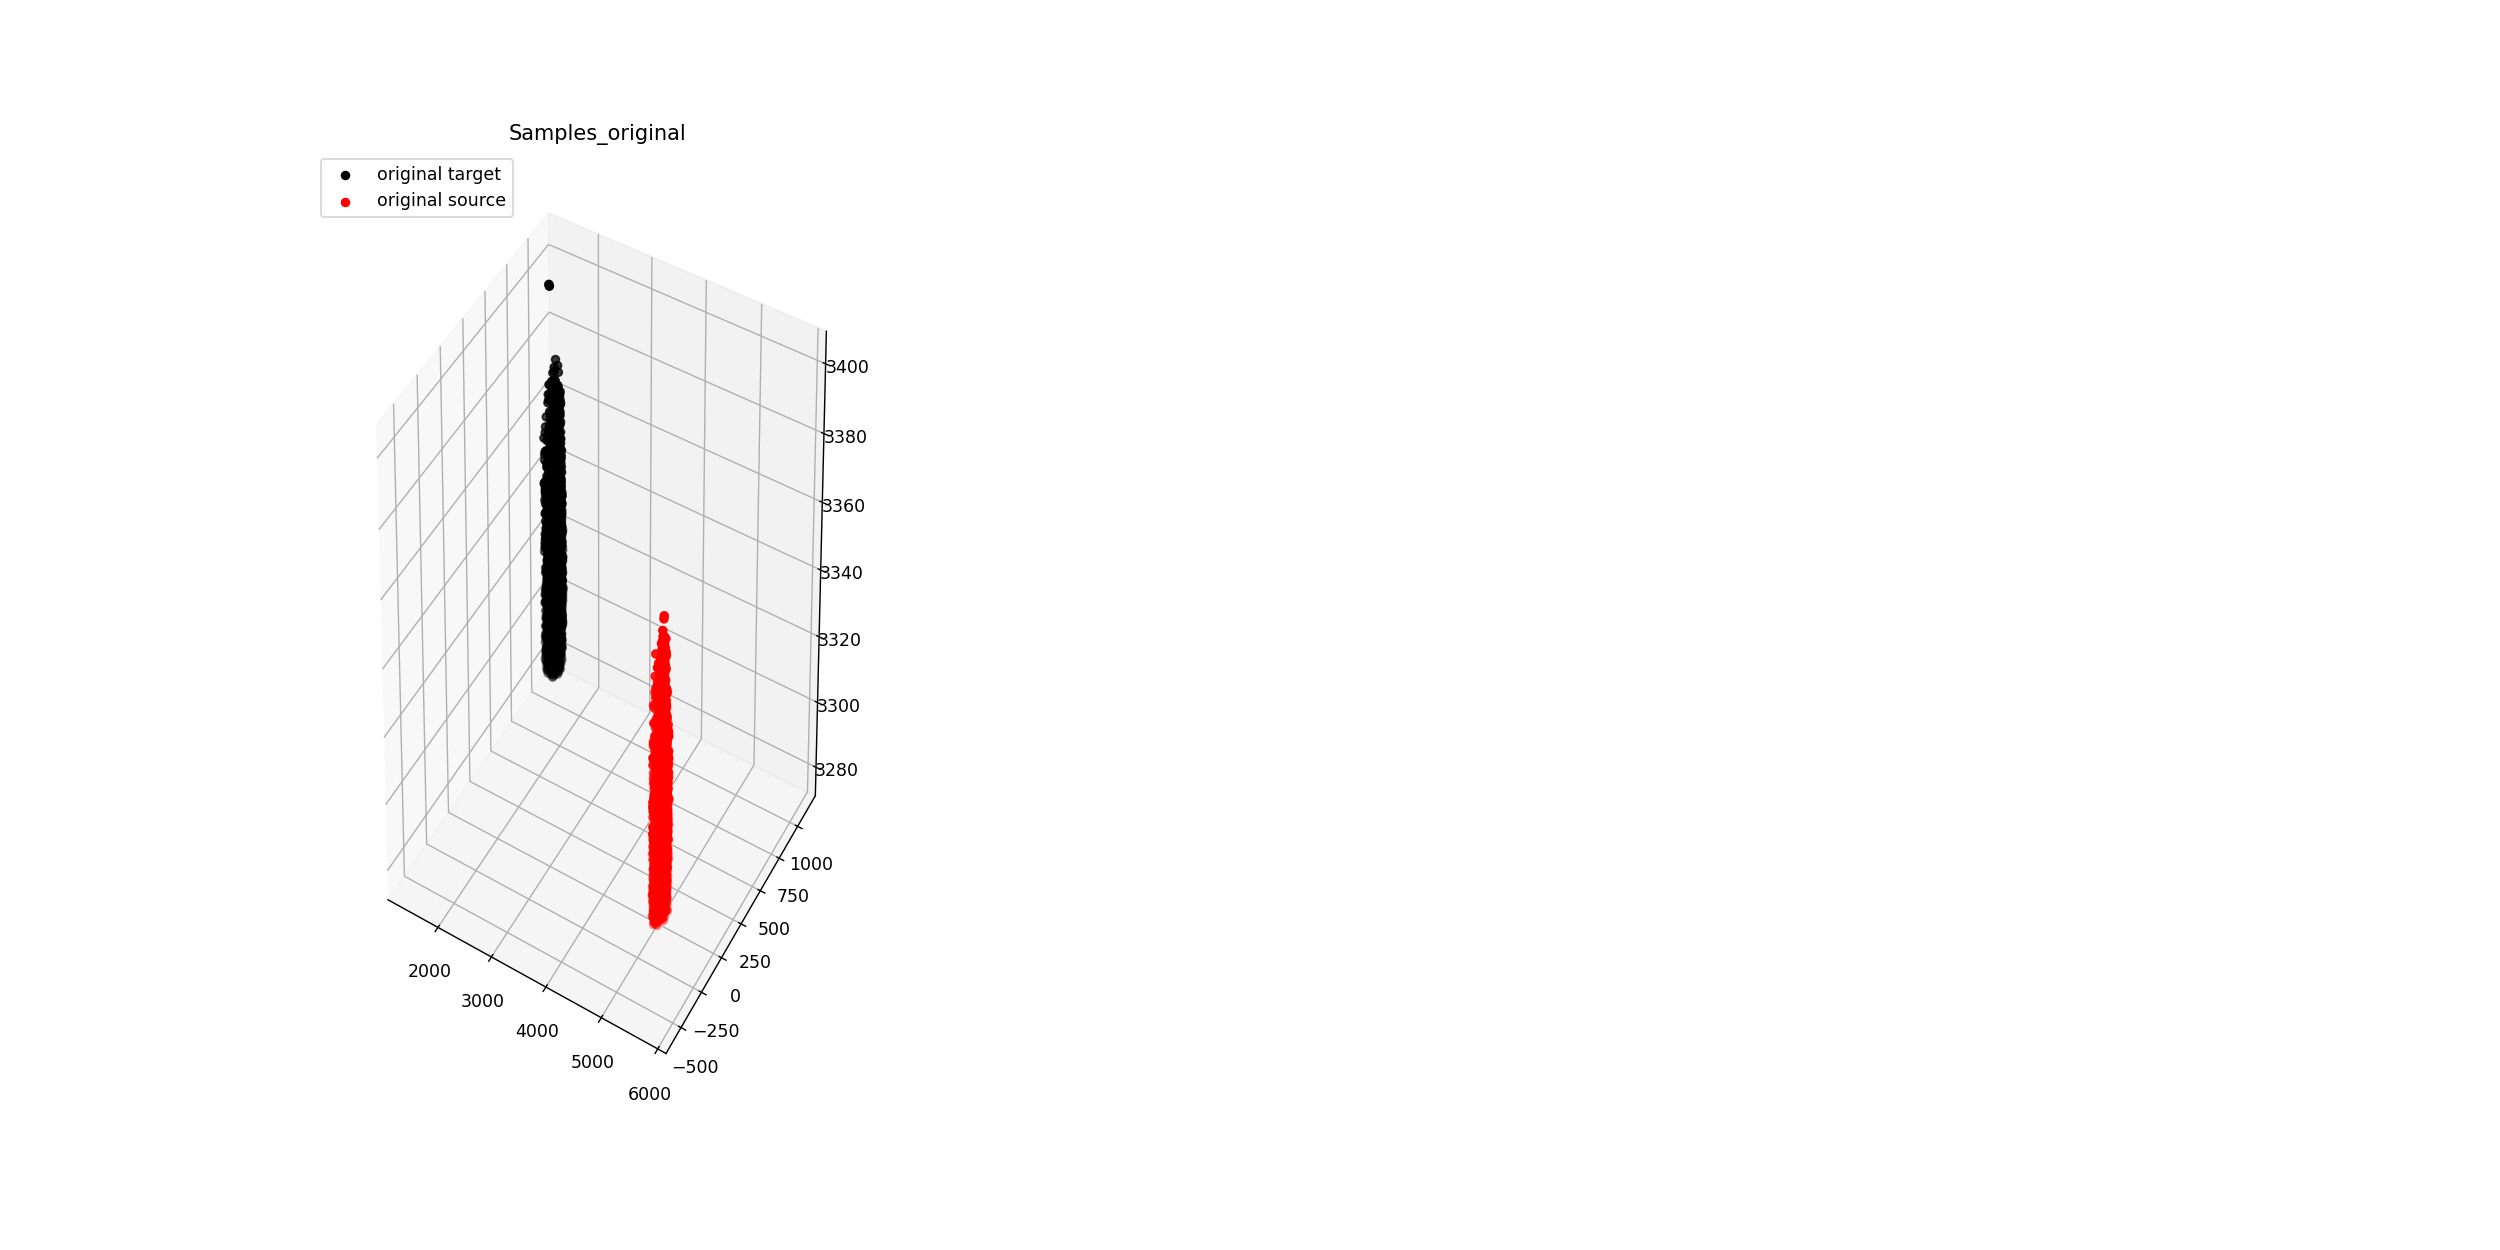

"\nax = fig.add_subplot(132, projection='3d')\nprocessed_source = np.asarray(source_processed.points)\nprocessed_target=np.asarray(target_processed.points)\nax.scatter(xs = processed_target[:,0], ys = processed_target[:,1], zs = processed_target[:,2], color='k',label = 'processed target')\nax.scatter(xs = processed_source[:,0], ys = processed_source[:,1], zs = processed_source[:,2], color='r',label = 'processed source')\nax.title.set_text('Samples_processed = original as downsampling = False')\nax.legend(loc='upper left')\n"

In [19]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(131, projection='3d')

original_source = np.asarray(source.points)
original_target=np.asarray(target.points)

ax.scatter(xs = original_target[:,0], ys = original_target[:,1], zs = original_target[:,2], color='k',label = 'original target')
ax.scatter(xs = original_source[:,0], ys = original_source[:,1], zs = original_source[:,2], color='r',label = 'original source')
ax.title.set_text('Samples_original')
ax.legend(loc='upper left')

"""
ax = fig.add_subplot(132, projection='3d')
processed_source = np.asarray(source_processed.points)
processed_target=np.asarray(target_processed.points)
ax.scatter(xs = processed_target[:,0], ys = processed_target[:,1], zs = processed_target[:,2], color='k',label = 'processed target')
ax.scatter(xs = processed_source[:,0], ys = processed_source[:,1], zs = processed_source[:,2], color='r',label = 'processed source')
ax.title.set_text('Samples_processed = original as downsampling = False')
ax.legend(loc='upper left')
"""


## sox2 expression of source point cloud

<IPython.core.display.Javascript object>


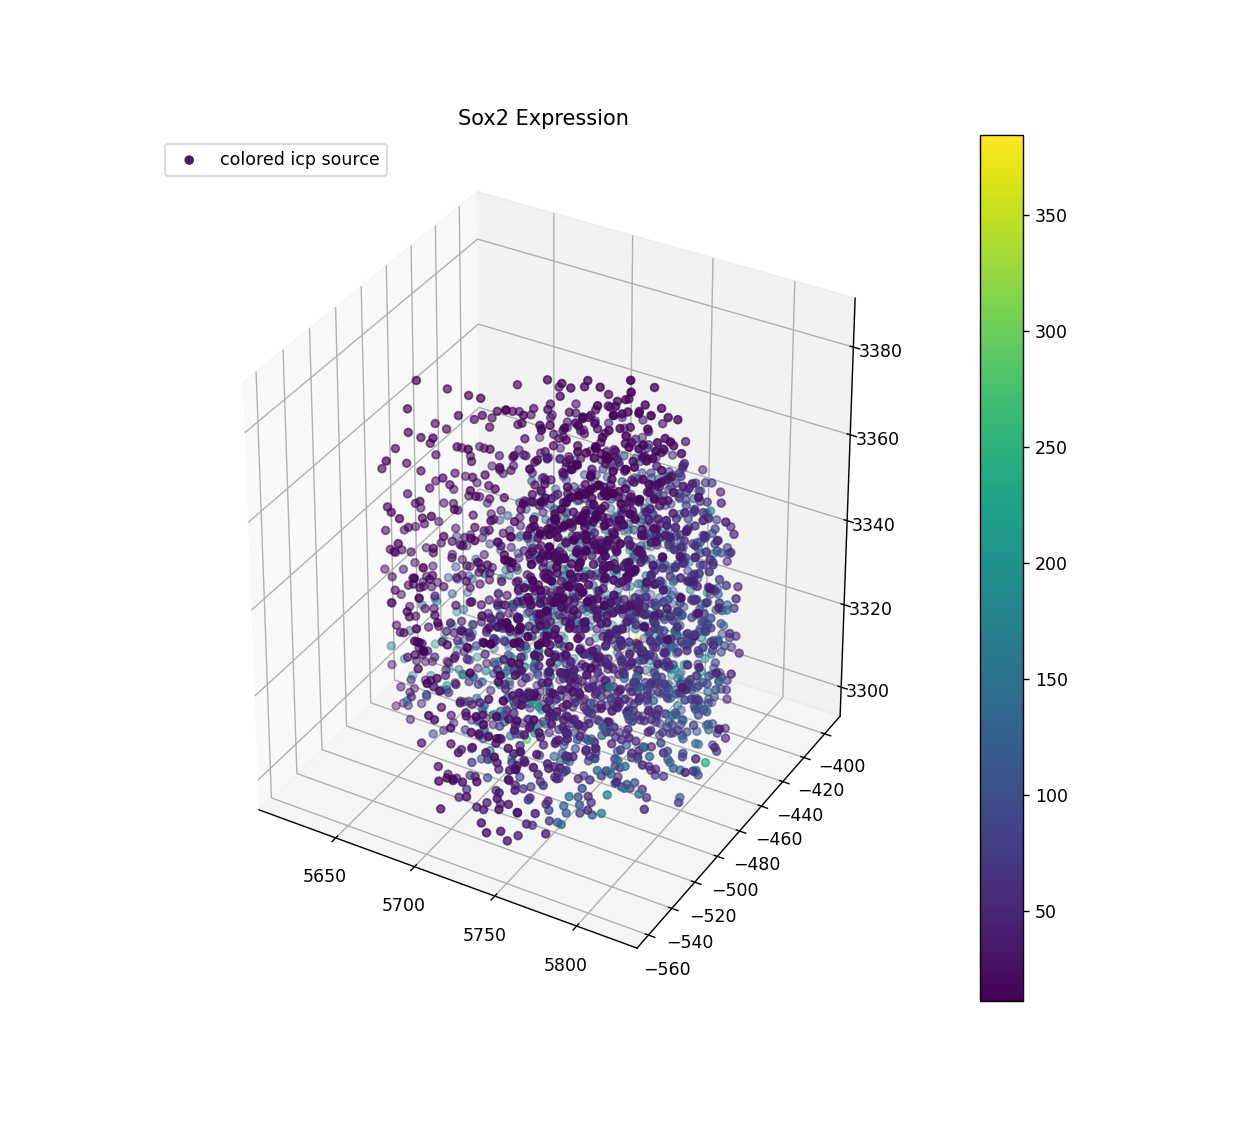

In [20]:
#plot points with colour

fig = plt.figure(figsize = (10,9))

source_ax = fig.add_subplot(111, projection='3d')
source_pts=np.asarray(source.points)
source_ax.scatter(xs = source_pts[:,0], ys = source_pts[:,1], zs = source_pts[:,2], color=source.colors,label = 'colored icp source')
source_ax.legend(loc='upper left')
source_ax.title.set_text('Sox2 Expression')
fig.colorbar(source_col_range)




## sox2 expression of target point cloud

<IPython.core.display.Javascript object>


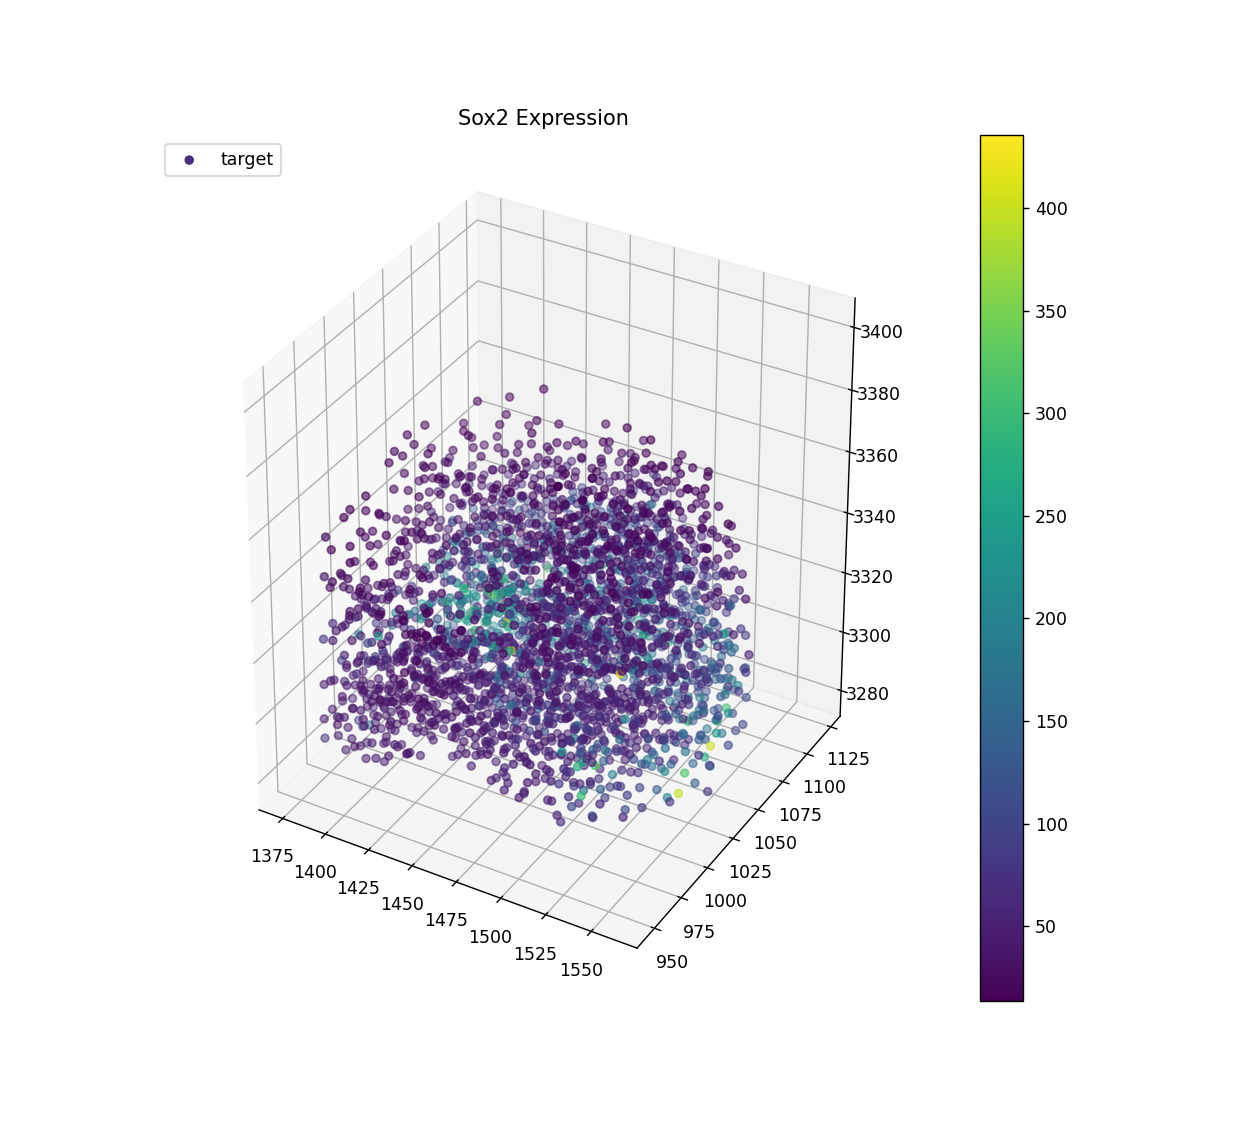

In [17]:
#plot points with colour
fig = plt.figure(figsize = (10,9))

target_ax=fig.add_subplot(111,projection='3d')
processed_target=np.asarray(target_processed.points)
target_ax.scatter(xs = processed_target[:,0], ys = processed_target[:,1], zs = processed_target[:,2], color=target_processed.colors,label = 'target')
target_ax.legend(loc='upper left')
target_ax.title.set_text('Sox2 Expression')
fig.colorbar(target_col_range)

plt.show()

# Approaches to registration:

We compare two approaches to registering the zebrafish tailbuds.

1. **Global to local registration approach**: [doc](http://www.open3d.org/docs/release/tutorial/Advanced/global_registration.html)

This approach first uses the RANSAC algorithm for global registration, which produces a coarser alignment which doesn't require an initial transformation. 

The global registration returns an object of the class `open3d.registration.RegistrationResult`, which possesses the `transformation` property. Using the result from the RANSAC algorithm as the initial transformation, we further fine-tune the registration by running the point-to-plane ICP algorithm for local alignment.

2. **Colored ICP approach**: [doc](http://www.open3d.org/docs/release/tutorial/Advanced/colored_pointcloud_registration.html)

This approach incorporates both geometry (xyz coordinates) and color information for registration, and should in principle, be more accurate and robust than the previous algorithm. The colored ICP algorithm is taken from [Park2017](https://openaccess.thecvf.com/content_ICCV_2017/papers/Park_Colored_Point_Cloud_ICCV_2017_paper.pdf).


## RANSAC (global) and ICP (local) registration

### Run RANSAC 

In [21]:
result_ransac = execute_global_registration(source_processed, target_processed,
                                            source_fpfh, target_fpfh,
                                            voxel_size, ransac_dist_modifier,ransac_edge_length)
source_aligned_ransac = copy.deepcopy(source_processed)
source_aligned_ransac.transform(result_ransac.transformation)

geometry::PointCloud with 2363 points.

In [22]:
result_ransac.transformation

array([[ 9.27821120e-01, -3.55220858e-01, -1.13868837e-01,
        -3.63532970e+03],
       [ 3.56858794e-01,  9.34136717e-01, -6.35573205e-03,
        -5.36171230e+02],
       [ 1.08626751e-01, -3.47381136e-02,  9.93475461e-01,
        -6.39588294e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

<IPython.core.display.Javascript object>


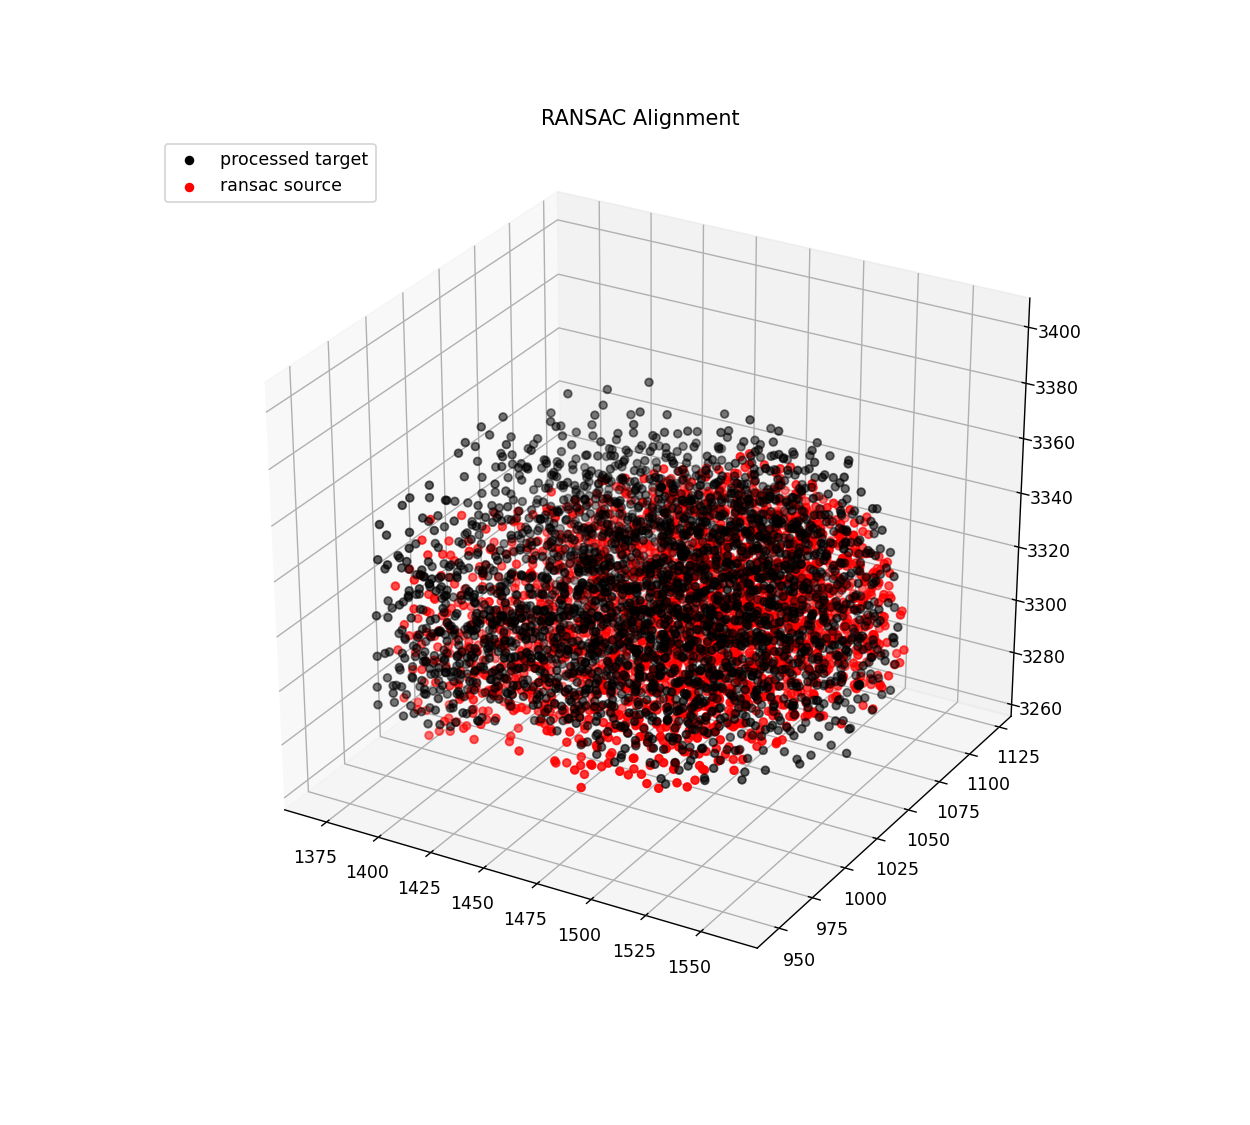

In [23]:
## Visualise globally registered point cloud with processed target
fig = plt.figure(figsize = (10,9))
ax = fig.add_subplot(111, projection='3d')

ransac_source=np.asarray(source_aligned_ransac.points)
processed_target=np.asarray(target_processed.points)

ax.scatter(xs = processed_target[:,0], ys = processed_target[:,1], zs = processed_target[:,2], color='k',label = 'processed target')
ax.scatter(xs = ransac_source[:,0], ys = ransac_source[:,1], zs = ransac_source[:,2], color='r',label = 'ransac source')
ax.legend(loc='upper left')
ax.title.set_text('RANSAC Alignment')

### Run ICP
Following the course registration of RANSAC, the RANSAC registration array is used as the transformation initiator (`trans_init`) for a local registration method - ICP.

This ICP is point to plane (this works better than point to point ICP)

In [24]:
result_icp = refine_registration(source, target, source_fpfh, target_fpfh, result_ransac.transformation, voxel_size)

source_aligned_icp= copy.deepcopy(source_processed)
source_aligned_icp.transform(result_icp.transformation)

geometry::PointCloud with 2363 points.

<IPython.core.display.Javascript object>


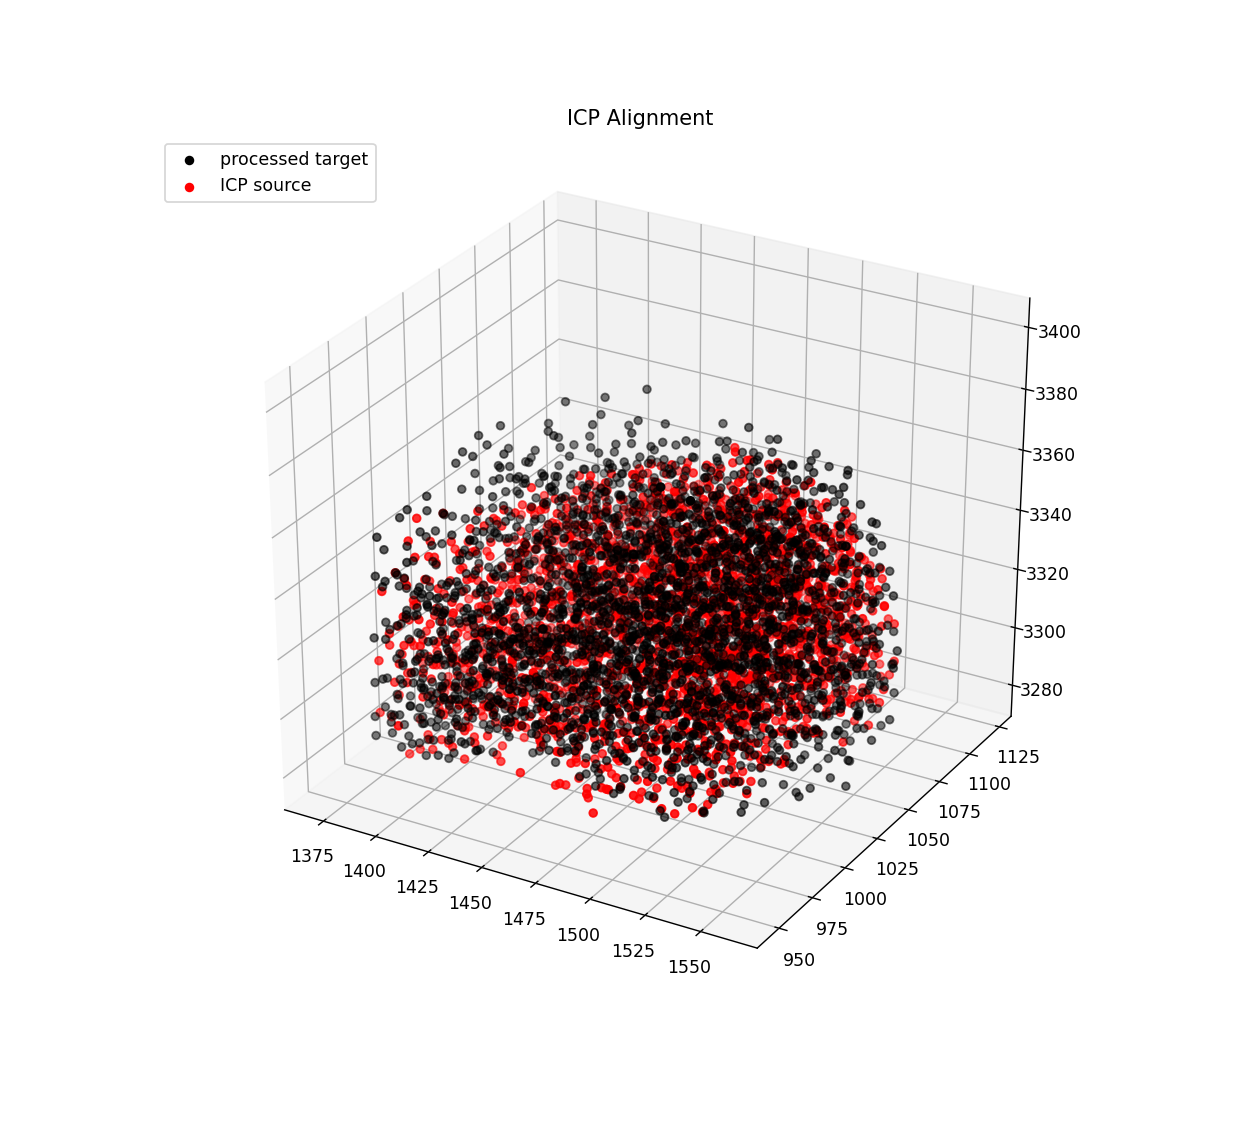

In [25]:
## Visualise locally registered point cloud with processed target
fig = plt.figure(figsize = (10,9))
ax = fig.add_subplot(111, projection='3d')

icp_source=np.asarray(source_aligned_icp.points)

ax.scatter(xs = processed_target[:,0], ys = processed_target[:,1], zs = processed_target[:,2], color='k',label = 'processed target')
ax.scatter(xs = icp_source[:,0], ys = icp_source[:,1], zs = icp_source[:,2], color='r',label = 'ICP source')
ax.legend(loc='upper left')
ax.title.set_text('ICP Alignment')


## Colored ICP registration

In [26]:
voxel_size=22
downsampling= False #whether or not to down sample point cloud to voxels of size "voxel_size"
norm_radius_modifier=95 #multiply by voxel size to get search radius when estimating normals
norm_maxnn=66 #maximum nearest neighbours for normal estimation
fpfh_radius_modifier=20 #multiply by voxel_size to get search radius when calculating fpfh feature
fpfh_maxnn=16 # maximum nearest neighbours for fpfh feature calculation
ransac_dist_modifier=32 # multiply by voxel_size for RANSAC distance threshold 
ransac_edge_length=1 # edge length for RANSAC correspondance checker pruning step
icp_dist_modifier=59 # multiply by voxel_size for ICP distance threshold 
max_iter = 40

In [27]:
# colored pointcloud registration modified from http://www.open3d.org/docs/release/tutorial/Basic/icp_registration.html
# This is implementation of following paper
# J. Park, Q.-Y. Zhou, V. Koltun,
# Colored Point Cloud Registration Revisited, ICCV 2017

downsample = False
voxel_radius = [30, 20, 10]
max_iter = [50, 30, 14]

def colored_icp(downsample, voxel_radius, max_iter):
    print("-- Initial global registration with RANSAC --")
    current_transformation = result_ransac.transformation
    #current_transformation = np.identity(4)

    source_colorreg = copy.deepcopy(source)
    target_colorreg = copy.deepcopy(target)

    for scale in range(len(voxel_radius)):
        print(f"-- colored point cloud registration round {scale+1} / {len(voxel_radius)} -- ")
        iter_ = max_iter[scale]
        radius = voxel_radius[scale]
        print([iter_, radius, scale])

        if downsample:
            print("3-1. Downsample with a voxel size %.2f" % radius)
            source_down = source_colorreg.voxel_down_sample(radius)
            target_down = target_colorreg.voxel_down_sample(radius)
        else:
            source_down = source_colorreg
            target_down = target_colorreg

        print("3-2. Estimate normal.")
        source_down.estimate_normals(
            o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))
        target_down.estimate_normals(
            o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))

        print("3-3. Applying colored point cloud registration")
        result_icp_colored = o3d.registration.registration_colored_icp(
            source_down, target_down, radius, current_transformation,
            o3d.registration.ICPConvergenceCriteria(relative_fitness=1e-6,
                                                    relative_rmse=1e-6,
                                                    max_iteration=iter_))
        current_transformation = result_icp_colored.transformation
        print(result_icp_colored)
    return result_icp_colored

#draw_registration_result_original_color(source, target, result_icp.transformation)
result_icp_colored = colored_icp(downsample, voxel_radius, max_iter)
source_aligned_coloredICP= copy.deepcopy(source)
source_aligned_coloredICP.transform(result_icp_colored.transformation)
    

-- Initial global registration with RANSAC --
-- colored point cloud registration round 1 / 3 -- 
[50, 30, 0]
3-2. Estimate normal.
3-3. Applying colored point cloud registration
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=4.642549e+00, and correspondence_set size of 2363
Access transformation to get result.
-- colored point cloud registration round 2 / 3 -- 
[30, 20, 1]
3-2. Estimate normal.
3-3. Applying colored point cloud registration
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=4.642614e+00, and correspondence_set size of 2363
Access transformation to get result.
-- colored point cloud registration round 3 / 3 -- 
[14, 10, 2]
3-2. Estimate normal.
3-3. Applying colored point cloud registration
registration::RegistrationResult with fitness=9.944985e-01, inlier_rmse=4.574393e+00, and correspondence_set size of 2350
Access transformation to get result.


geometry::PointCloud with 2363 points.

In [28]:
source_aligned_coloredICP

geometry::PointCloud with 2363 points.

### Visualisation of alignment

<IPython.core.display.Javascript object>


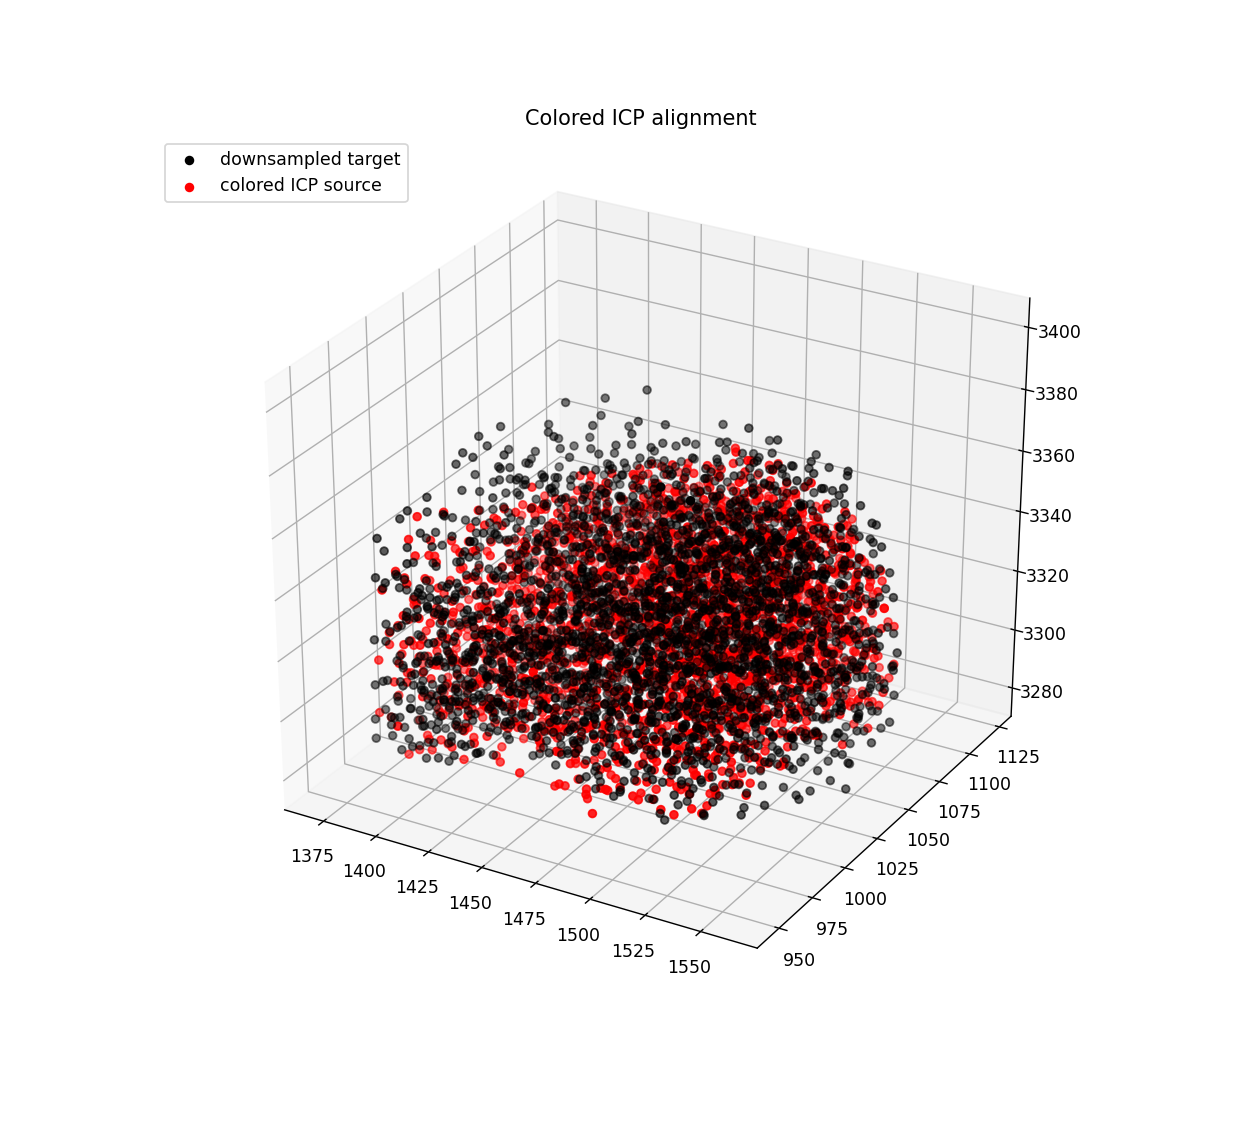

In [29]:
#fig = plt.figure(figsize = (60,20))
fig = plt.figure(figsize = (10,9))

source_colorreg = copy.deepcopy(source)
target_colorreg = copy.deepcopy(target)
target_down_pts = np.array(target_colorreg.points)
source_down_pts = np.array(source_colorreg.points)
source_reg_pts = np.array(source_aligned_coloredICP.points)
"""
ax = fig.add_subplot(121, projection='3d')
ax.scatter(xs = target_down_pts[:,0], ys = target_down_pts[:,1], zs = target_down_pts[:,2], color='k',label = 'downsampled target')
ax.scatter(xs = source_down_pts[:,0], ys = source_down_pts[:,1], zs = source_down_pts[:,2], color='r',label = 'downsampled source')
ax.title.set_text('Pre-alignment')
ax.legend(loc='upper left')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(xs = target_down_pts[:,0], ys = target_down_pts[:,1], zs = target_down_pts[:,2], color='k',label = 'downsampled target')
ax.scatter(xs = source_reg_pts[:,0], ys = source_reg_pts[:,1], zs = source_reg_pts[:,2], color='r',label = 'ransac source')
ax.legend(loc='upper left')
ax.title.set_text('Colored ICP alignment')

"""
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs = target_down_pts[:,0], ys = target_down_pts[:,1], zs = target_down_pts[:,2], color='k',label = 'downsampled target')
ax.scatter(xs = source_reg_pts[:,0], ys = source_reg_pts[:,1], zs = source_reg_pts[:,2], color='r',label = 'colored ICP source')
ax.legend(loc='upper left')
ax.title.set_text('Colored ICP alignment')


## Results of alignment

In [30]:
print(":: Unaligned")
evaluation = o3d.registration.evaluate_registration(source_processed, target_processed, voxel_size * icp_dist_modifier )
print(evaluation)

print(":: Result of RANSAC global registration: ")
print(result_ransac)
#print("RANSAC Transformation is:")
#print(result_ransac.transformation)

print(":: Result of additional ICP local registration with max convergence = 2000 iterations: ")
print(result_icp)
#print("ICP Transformation is:")
#print(result_icp.transformation)

print(":: Result of Colored ICP registration ")
print(result_icp_colored)
#print("Colored ICP Transformation is:")
#print(result_icp_colored.transformation)

:: Unaligned
registration::RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
:: Result of RANSAC global registration: 
registration::RegistrationResult with fitness=9.949217e-01, inlier_rmse=5.179630e+00, and correspondence_set size of 2351
Access transformation to get result.
:: Result of additional ICP local registration with max convergence = 2000 iterations: 
registration::RegistrationResult with fitness=9.944985e-01, inlier_rmse=4.569764e+00, and correspondence_set size of 2350
Access transformation to get result.
:: Result of Colored ICP registration 
registration::RegistrationResult with fitness=9.944985e-01, inlier_rmse=4.574393e+00, and correspondence_set size of 2350
Access transformation to get result.


## Visualisation of correspondence set

http://www.open3d.org/docs/release/python_api/open3d.geometry.LineSet.html?highlight=correspondence

create_from_point_cloud_correspondence


<IPython.core.display.Javascript object>


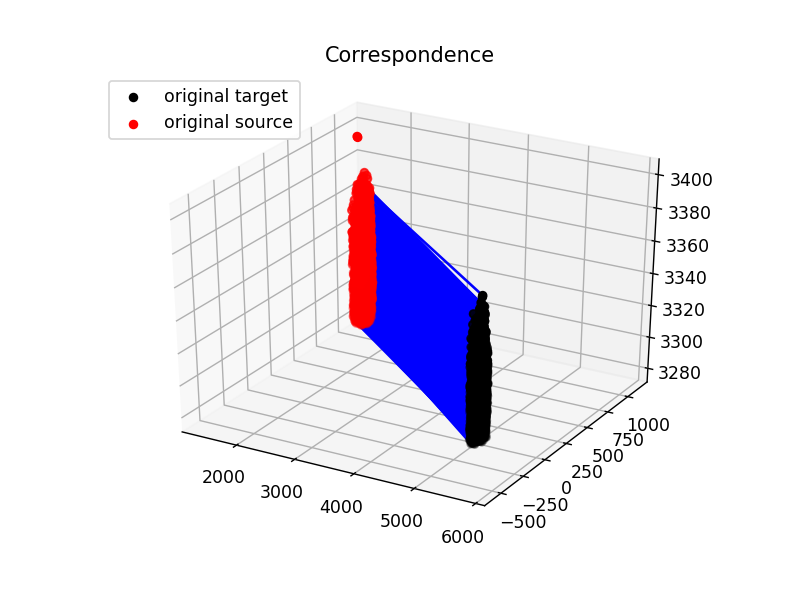

In [31]:
corr_result = np.array(result_icp_colored.correspondence_set)
source_indices = corr_result[:,0]
target_indices = corr_result[:,1]

source_pts = np.array(source.points)
target_pts = np.array(target.points)
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

ax.scatter(xs = source_pts[:,0], ys = source_pts[:,1], zs = source_pts[:,2], color='k',label = 'original target')
ax.scatter(xs = target_pts[:,0], ys = target_pts[:,1], zs = target_pts[:,2], color='r',label = 'original source')
ax.title.set_text('Correspondence')
ax.legend(loc='upper left')

for i in range(len(corr_result)):
    source_x = source_pts[source_indices][i][0]
    target_x = target_pts[target_indices][i][0]
    source_y = source_pts[source_indices][i][1]
    target_y = target_pts[target_indices][i][1]
    source_z = source_pts[source_indices][i][2]
    target_z = target_pts[target_indices][i][2]
    x = [source_x, target_x]
    y = [source_y, target_y]
    z = [source_z, target_z]
    ax.plot(x, y, z, color= 'b')
    

#https://stackoverflow.com/questions/11541123/how-can-i-make-a-simple-3d-line-with-matplotlib

# Approaches to validation:

We calculate the RMSE of the sox2 intensity levels between the source and target points. The sets of points to be compared are given to us by the correspondence set (see below for more details).


## The correspondence_set property 

To validate the registration result, we will compare the sox2 intensity expression of the target and source points. Specifically, the registration algorithms return an object of the class `open3d.registration.RegistrationResult`, which possesses the `correspondence set` property. This is an `nx2 int numpy array` that establishes the correspondence between the source and target point clouds.



### Implementation details:

The first column of the numpy array contains the indices of the source point cloud, whilst the second column holds the indices of the target point cloud. As each source point is mapped uniquely to a target point, the correspondence set size is upper bounded by the size of the source point cloud. 

To summarise the properties of the map:
1. Source point cloud:

    - Each source point in the map is unique
    - Not all of the source points are included in the map 
    

2. Target point cloud:
    - Not all target point clouds are mapped to. 

    > K: We need to explore this as a possible concern. What if images are imaged at different depths? Perhaps we need to stipulate that the imaris processing should create spots up to the notochord only to ensure that a roughly equal z-thickness is used for mapping 

    - Multiple source points can map to the same target point

#### Which points are excluded from the correspondence list?

<IPython.core.display.Javascript object>


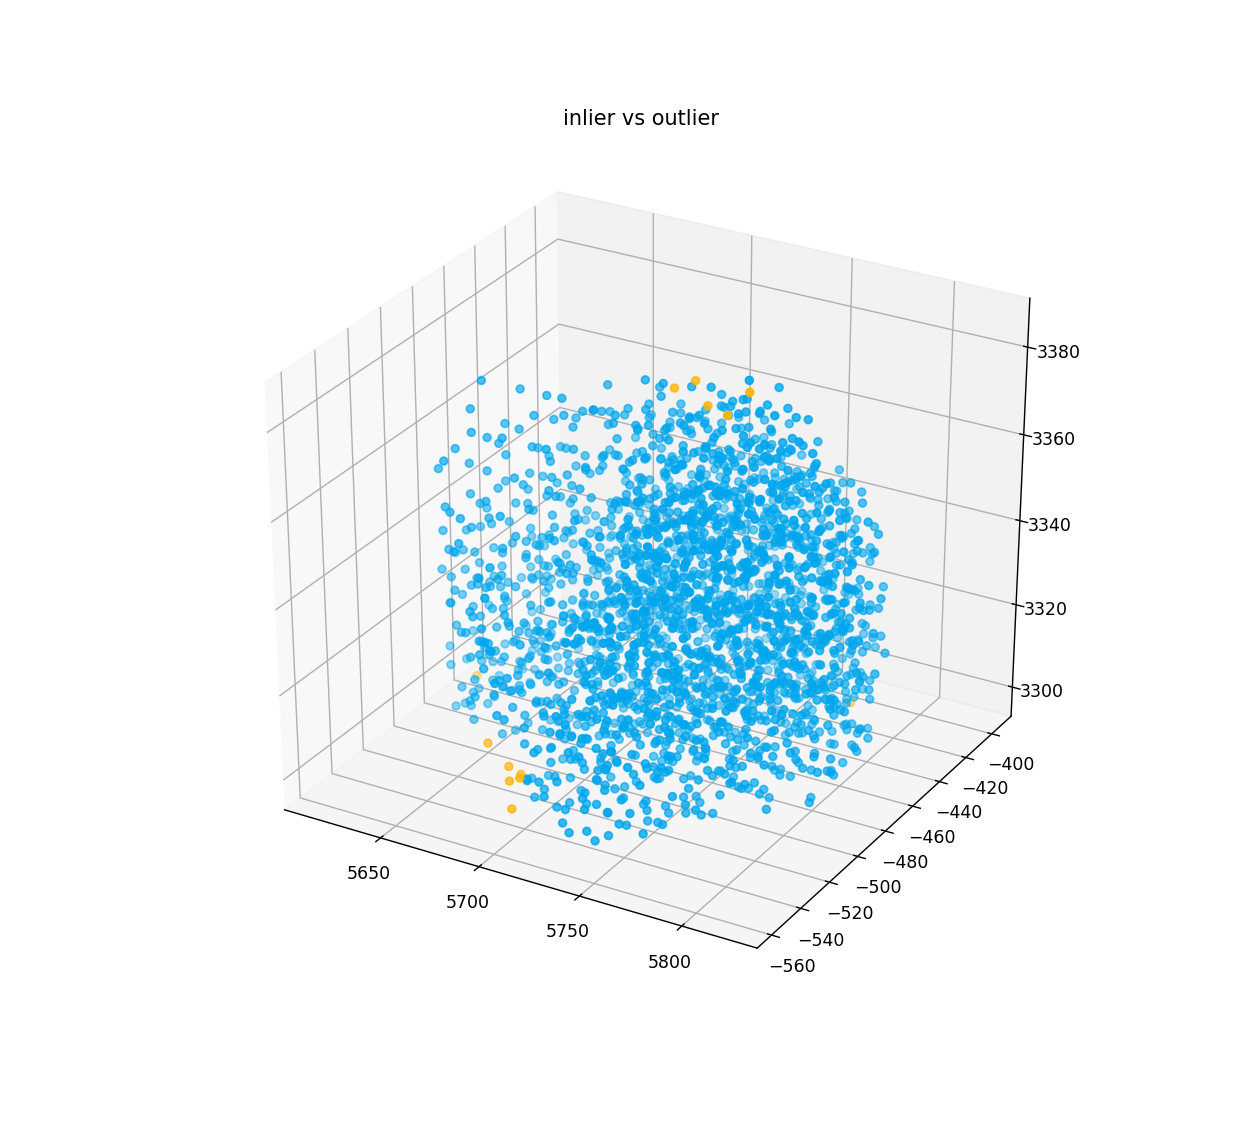

In [32]:
corr_result = np.array(result_icp_colored.correspondence_set)

source_indices = corr_result[:,0]
source_range = np.arange(0,(np.array(source.points).shape)[0])

outlier_indices = np.where(np.invert(np.in1d(source_range, source_indices)))[0]
#print (len(source_indices) + len(outlier_indices)== (np.array(source.points).shape)[0])

source_new = copy.deepcopy(source)
colors = np.zeros(np.shape(np.array(source_new.colors)))
colors[outlier_indices] = [1, 0.706, 0] #yellow
colors[source_indices] = [0, 0.651, 0.929] # cyan
source_new.colors=o3d.utility.Vector3dVector(colors)

fig = plt.figure(figsize = (10,9))

source_ax=fig.add_subplot(111,projection='3d')
source_new_pts =np.asarray(source_new.points)
source_ax.scatter(xs = source_new_pts[:,0], ys = source_new_pts[:,1], zs = source_new_pts[:,2], color=source_new.colors)
source_ax.title.set_text('inlier vs outlier')


#### Dimensions of correspondence list

In [38]:
print(corr_result.shape == np.array(source.points).shape)  # Not all of the source points are included in the map 
print(np.array(target.points).shape)
print(corr_result)
print(np.amax(corr_result[:,1])) #First column is source; second column is target

print(len(set(corr_result[:,0].tolist())) == len(corr_result)) #Each source point in the map is unique

print(len(set(corr_result[:,1].tolist())) == len(corr_result)) #Multiple points from source mapped onto same target point

target_range = np.arange(0, np.array(target.points).shape[0])
unmapped_targets =np.where(np.invert(np.in1d(target_range, corr_result[:,1])))[0]

print(f"There are {len(unmapped_targets)} unmapped targets") #1212

False
(2878, 3)
[[1677 1786]
 [1678 1464]
 [1679 1816]
 ...
 [1478 1723]
 [1479 2033]
 [1480 1664]]
2862
True
False
There are 1204 unmapped targets


## Mean absolute deviation (MAE) of sox2 intensities

In [39]:
def min_max_normalisation(intensity_values):
    # Input a numpy array of intensity values
    min_val = np.amin(intensity_values)
    max_val = np.amax(intensity_values)
    output = (intensity_values - min_val) / (max_val - min_val) *100 
    return output

norm_colors_source = min_max_normalisation(sox2_source)
norm_colors_target = min_max_normalisation(sox2_target)

def mae(source_val, target_val):
    try:
        assert source_val.shape == target_val.shape   
        
    except:
        print("source and target intensity values must be of the same shape")
    
    else:
        mae = (sum(abs(source_val - target_val))) / (source_val.shape[0])
    return mae

    

### RANSAC vs target_processed

In [40]:
corr_result_ransac = np.array(result_ransac.correspondence_set)
source_indices_ransac = corr_result_ransac[:,0]
target_indices_ransac = corr_result_ransac[:,1]
sox2_source_ransac = norm_colors_source[source_indices_ransac]
sox2_target_ransac = norm_colors_target[target_indices_ransac]

result_mae_ransac = mae(sox2_source_ransac, sox2_target_ransac)[0]
result_mae_ransac

9.640257581017812

### ICP (post-RANSAC) vs target_processed

In [43]:
corr_result_icp = np.array(result_icp.correspondence_set)
source_indices_icp = corr_result_icp[:,0]
target_indices_icp = corr_result_icp[:,1]

sox2_source_icp = norm_colors_source[source_indices_icp]
sox2_target_icp = norm_colors_target[target_indices_icp]

result_mae_icp = mae(sox2_source_icp, sox2_target_icp)[0]
result_mae_icp

9.771839372282164

### Colored ICP vs target_processed

In [44]:
corr_result_col_icp = np.array(result_icp_colored.correspondence_set)
source_indices_col_icp = corr_result_col_icp[:,0]
target_indices_col_icp = corr_result_col_icp[:,1]
sox2_source_col_icp = norm_colors_source[source_indices_col_icp]
sox2_target_col_icp = norm_colors_target[target_indices_col_icp]

result_mae_col_icp = mae(sox2_source_col_icp, sox2_target_col_icp)[0]
result_mae_col_icp

9.741854854891484

# Multi-objective optimization with genetic algorithms:

Limitations of using a grid search method for optimising each registration algorithm: 

It suffers from the curse of dimensionality from performing an exhaustive search, where the number of hyperparameter combinations increases exponentially. E.g. for 10 parameters with a range of 5 integer values, there are $5^{10} = 19513125$ parameter combinations to test, which requires evaluating the registration algorithms around 20 million times.

Inputs : 
1. xyz_source 
2. xyz_target 
3. sox2_source 
4. sox2_target 

Output: 
1. result_ransac.fitness
2. result_ransac.inlier_rmse
3. result_icp.fitness
4. result_icp.inlier_mse
5. result_icp_colored.fitness
6. result_icp_colored.inlier_rmse

Query:
1. What to do to weights, since fitness, inlier_rmse and mae may be on different scales???


## Importing packages and useful docs



In [43]:
import random
from deap import algorithms, base, creator, tools

In [44]:
filenames = positions_names
norm_colors_source = min_max_normalisation(sox2_source)
norm_colors_target = min_max_normalisation(sox2_target)

## DEAP (simple) evolution 

https://github.com/DEAP/deap/blob/38083e5923274dfe5ecc0586eb295228f8c99fc4/examples/ga/onemax.py


### Evaluation functions

In [154]:
def evaluation_ransac(individual):
    
    """
    For a particular combination of hyperparameters, return the fitness, inlier_mse and mae values in a 3-element tuple
    
    param_grid = {'voxel_size': np.linspace(0.1,100,5), 
              'downsampling' : np.array([True, False]),
              'norm_radius_modifier':  np.linspace(1,100,5),
              'norm_maxnn' :  np.linspace(1,100,5),
              'fpfh_radius_modifier':  np.linspace(1,100,5),
              'fpfh_maxnn':  np.linspace(1,100,5),
              'ransac_dist_modifier':  np.linspace(1,100,5),
              'ransac_edge_length':  np.linspace(1,100,5),
              'icp_dist_modifier' :  np.linspace(1,100,5),
              'max_iter':  np.linspace(10,100,5)              
             }
    """
    #print(individual)
    source, target, source_processed, target_processed, source_fpfh, target_fpfh = prepare_dataset(filenames, individual[0], individual[1],individual[2],individual[3],individual[4],individual[5])
    
    target.colors=o3d.utility.Vector3dVector(target_rgb)
    source.colors=o3d.utility.Vector3dVector(source_rgb) #assign to colour component of registered point cloud
    
    result_ransac = execute_global_registration(source_processed, target_processed,
                                            source_fpfh, target_fpfh,
                                            individual[0], individual[6],individual[7])
    
    corr_result_ransac = np.array(result_ransac.correspondence_set)
    
    if len(corr_result_ransac) == 0:
        result_ransac.inlier_rmse = 10000
        result_mae_ransac = 10000
    
    else:
        source_indices_ransac = corr_result_ransac[:,0]
        target_indices_ransac = corr_result_ransac[:,1]
        sox2_source_ransac = norm_colors_source[source_indices_ransac]
        sox2_target_ransac = norm_colors_target[target_indices_ransac]
        result_mae_ransac = mae(sox2_source_ransac, sox2_target_ransac)[0]
        
    print("Result of evaluation-", result_ransac.fitness,result_ransac.inlier_rmse, result_mae_ransac)
    return (result_ransac.fitness,result_ransac.inlier_rmse, result_mae_ransac)


def evaluation_icp(individual):
    
    """
    For a particular combination of hyperparameters, return the fitness, inlier_mse and mae values in a 3-element tuple
    
    param_grid = {'voxel_size': np.linspace(0.1,100,5), 
              'downsampling' : np.array([True, False]),
              'norm_radius_modifier':  np.linspace(1,100,5),
              'norm_maxnn' :  np.linspace(1,100,5),
              'fpfh_radius_modifier':  np.linspace(1,100,5),
              'fpfh_maxnn':  np.linspace(1,100,5),
              'ransac_dist_modifier':  np.linspace(1,100,5),
              'ransac_edge_length':  np.linspace(1,100,5),
              'icp_dist_modifier' :  np.linspace(1,100,5),
              'max_iter':  np.linspace(10,100,5)              
             }
    """
    source, target, source_processed, target_processed, source_fpfh, target_fpfh = prepare_dataset(filenames, individual[0], individual[1],individual[2],individual[3],individual[4],individual[5])
    
    target.colors=o3d.utility.Vector3dVector(target_rgb)
    source.colors=o3d.utility.Vector3dVector(source_rgb)
    
    result_ransac = execute_global_registration(source_processed, target_processed,
                                            source_fpfh, target_fpfh,
                                            individual[0], individual[6],individual[7])
    
    result_icp= refine_registration(source, target, source_fpfh, target_fpfh, result_ransac.transformation, voxel_size)
    
    corr_result_icp = np.array(result_icp.correspondence_set)
    
    if len(corr_result_icp) == 0:
        result_icp.inlier_rmse = 10000
        result_mae_icp = 10000
    
    else:
    source_indices_icp = corr_result_icp[:,0]
    target_indices_icp = corr_result_icp[:,1]
    sox2_source_icp = norm_colors_source[source_indices_icp]
    sox2_target_icp = norm_colors_target[target_indices_icp]

    result_mae_icp = mae(sox2_source_icp, sox2_target_icp)[0]
    
    return (result_icp.fitness,result_icp.inlier_rmse, result_mae_icp)


def evaluation_colored_icp(individual):
    
    """
    For a particular combination of hyperparameters, return the fitness, inlier_mse and mae values in a 3-element tuple
    
    param_grid = {'voxel_size': np.linspace(0.1,100,5), 
              'downsampling' : np.array([True, False]),
              'norm_radius_modifier':  np.linspace(1,100,5),
              'norm_maxnn' :  np.linspace(1,100,5),
              'fpfh_radius_modifier':  np.linspace(1,100,5),
              'fpfh_maxnn':  np.linspace(1,100,5),
              'ransac_dist_modifier':  np.linspace(1,100,5),
              'ransac_edge_length':  np.linspace(1,100,5),
              'icp_dist_modifier' :  np.linspace(1,100,5),
              'max_iter':  np.linspace(10,100,5)              
             }
    """
    source, target, source_processed, target_processed, source_fpfh, target_fpfh = prepare_dataset(filenames, individual[0], individual[1],individual[2],individual[3],individual[4],individual[5])
    
    target.colors=o3d.utility.Vector3dVector(target_rgb)
    source.colors=o3d.utility.Vector3dVector(source_rgb)
    
    result_colored_icp = colored_icp(individual[1], individual[0], individual[9])
  
    
    corr_result_col_icp = np.array(result_icp_colored.correspondence_set)
    
    if len(corr_result_col_icp) == 0:
        result_colored_icp.inlier_rmse = 10000
        result_mae_col_icp = 10000
    
    else:
    source_indices_col_icp = corr_result_col_icp[:,0]
    target_indices_col_icp = corr_result_col_icp[:,1]
    sox2_source_col_icp = norm_colors_source[source_indices_col_icp]
    sox2_target_col_icp = norm_colors_target[target_indices_col_icp]

    result_mae_col_icp = mae(sox2_source_col_icp, sox2_target_col_icp)[0]
    
    return (result_colored_icp.fitness,result_colored_icp.inlier_rmse, result_mae_col_icp)





In [155]:
def mutation(individual, indpb):
    """ Individual is a list of 10 elements, with the element in the second position (index 1) of the list
    being a boolean variable. With the exception of the boolean variable, we mutate the attribute by 
    sampling from a uniform distribution and adding 1 if p >=0.5, and subtracting 1 otherwise, ensuring
    that integer values are returned. The attribute values are constrained to be positive for compatibility with 
    the registration algorithms. 
    
    Individual: list of size = len(individual)
    indpb: list of size = len(individual) 
    
    """
    downsampling_val = individual[1] #Storing the boolean 
    downsampling_indpb = indpb[1] #Storing the boolean mut probability
    del individual[1] #Removing the boolean for now to facilitate looping
    del indpb[1]
    
    size = len(individual)
    for i, p in zip(range(size),indpb):
        if random.random() < p: #If the mutation occurs:
            current_val = individual[i]
            random_num = random.random() 
            if random_num >= 0.5:
                individual[i] -= 1
                if individual[i] <= 0:
                    individual[i] = current_val # In the event that the mutation causes the val to be <=0, we keep the original value.
            else:
                individual[i] +=1       
            
    random_for_boolean = random.random()
    if random_for_boolean < downsampling_indpb:
        downsampling_val = not downsampling_val
    
    individual.insert(1, downsampling_val)
    indpb.insert(1, downsampling_indpb)
    
    return individual
    

### RANSAC main body

In [203]:
# results.fitness (MAX), results.inlier_mse (MIN), mae (MIN)
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0, -1.0)) 

# A list-type individual with a fitness attribute
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Instantiate a Toolbox to register all the evolutionary operators.
toolbox = base.Toolbox()

# We define a generator operator, with the alias `generator`, which generates the values for the individuals.

def generator():
    """Describe how to generate values for each parameter.
    """
    voxel_size = random.choice(range(2,30,5 ))
    downsampling = random.choice([True, False])
    norm_radius_modifier= random.choice(range(2,10,2 ))
    norm_maxnn= random.choice(range(2,100,5 ))
    fpfh_radius_modifier = random.choice(range(2,10,2 ))
    fpfh_maxnn= random.choice(range(2,100,5 ))
    ransac_dist_modifier= random.choice(range(2,10,2 ))
    ransac_edge_length= random.choice(range(2,100,5 ))
    icp_dist_modifier= random.choice(range(2,10,2 ))
    max_iter= random.choice(range(10,100,5 ))
    
    return [voxel_size, downsampling, norm_radius_modifier, norm_maxnn, fpfh_radius_modifier,
           fpfh_maxnn, ransac_dist_modifier, ransac_edge_length, icp_dist_modifier, max_iter] 


toolbox.register("generator", generator)

# Structure initializers
# define 'individual' to be a single individual taking up the values generated by the toolbox.generator. So we don't 
# need to repeat the toolbox.generator function. 
# This gives us flexibilty to define each parameter with its unique distribution, instead of keeping the distribution
# the same and applying it repeatedly across each parameter.

toolbox.register("individual", tools.initIterate, creator.Individual, 
    toolbox.generator) 

# define the population to be a list of individuals # We don't define n here, but in the main body to give flexibility to num individuals.
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operator registration
#----------
# register the goal / fitness function
toolbox.register("evaluate", evaluation_ransac)

# register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# register a mutation operator 

toolbox.register("mutate", mutation, indpb = [0.2]*10)

# operator for selecting individuals for breeding the next
# generation: each individual of the current generation
# is replaced by the 'fittest' (best) of three individuals
# drawn randomly from the current generation.
toolbox.register("select", tools.selTournament, tournsize=3)


In [3]:
import numpy as np
a = np.array([])
a.size

b = np.array([1,2,3])
b.size

3

### Running GA for RANSAC

In [248]:
def main(num_ind, num_gen, best_k, run_name):
    random.seed(64)

    # create an initial population of 300 individuals (where
    # each individual is a list of integers)
    pop = toolbox.population(n=num_ind)

    # CXPB  is the probability with which two individuals are crossed
    # MUTPB is the probability for mutating an individual
    CXPB, MUTPB = 0.7, 0.7

    print("Start of evolution")
    
    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
        
    print("  Evaluated %i individuals" % len(pop))
    
    ## Creating logbook for recording statistics

    stats_o3d_fitness = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats_o3d_rmse = tools.Statistics(lambda ind: ind.fitness.values[1])
    stats_o3d_mae = tools.Statistics(lambda ind: ind.fitness.values[2])
    mstats = tools.MultiStatistics(o3d_fitness=stats_o3d_fitness, 
                                   o3d_rmse =stats_o3d_rmse,
                                   o3d_mae = stats_o3d_mae)
    
    mstats.register("mean", lambda ind: sum(ind)/len(pop))
    mstats.register("max", lambda ind: np.max(ind))
    mstats.register("min", lambda ind: np.min(ind))
    
    logbook = tools.Logbook()
    logbook.header = ["gen", "evals", "o3d_fitness", "o3d_rmse", "o3d_mae"]
    logbook.chapters["o3d_fitness"].header = ["mean", "max"]
    logbook.chapters["o3d_rmse"].header = ["mean", "min"]
    logbook.chapters["o3d_mae"].header = ["mean", "min"]
    
    # Variable keeping track of the number of generations
    g = 0
    
    # List keeping track of best k number of individuals for each generation.
    best_k_ind = []
    
    # Begin the evolution
    while g < num_gen:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))

        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
        
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cross two individuals with probability CXPB
            if random.random() < CXPB:
                toolbox.mate(child1, child2)

                # fitness values of the children
                # must be recalculated later
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        print("  Evaluated %i individuals" % len(invalid_ind))
        
        # The population is entirely replaced by the offspring
        pop[:] = offspring
        
        # Logging records into logbook
        record = mstats.compile(pop)
        logbook.record(gen=g, evals=len(pop), **record)
        
        # Updating best_k_ind dictionary
        best_ind = tools.selBest(pop, best_k)
        fitnesses = [list(ind.fitness.values) for ind in best_ind]
        mapped_ind = list(zip(best_ind, fitnesses))
        for ind, fitness in mapped_ind:
            temp = {"gen":g , "individual": ind, "o3d_fitness" : fitness[0], 
                              "o3d_rmse" : fitness[1], "o3d_mae" : fitness[2]}
            best_k_ind.append(temp)
                 
    print("-- End of (successful) evolution --")
    
    ## Fittest individuals from the population
    
    #best_ind = tools.selBest(pop, 1)[0]
    #print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    #result_top10 = np.array(tools.selBest(pop,10))
    best_k_ind_df = pd.DataFrame(best_k_ind)      
    print(best_k_ind_df)

    ## Saving best individuals and logbook
    newpath = run_name

    if not os.path.exists(newpath):
        os.makedirs(newpath)
           
    #np.save(file = f"{newpath}/result_ransac_df.csv", arr = best_k_ind_df)
    best_k_ind_df.to_csv(f'{newpath}/result_ransac_best.csv', index=False) 
    
    results = {"gen" : logbook.select("gen"),
                "eval" : logbook.select("eval"),
                "o3d_fitness_mean" : logbook.chapters['o3d_fitness'].select("mean"),
                "o3d_fitness_max" : logbook.chapters['o3d_fitness'].select("max"),
                "o3d_rmse_mean" : logbook.chapters['o3d_rmse'].select("mean"),
                "o3d_rmse_min" : logbook.chapters['o3d_rmse'].select("min"),
                "o3d_mae_mean" : logbook.chapters['o3d_mae'].select("mean"),
                "o3d_mae_min" : logbook.chapters['o3d_mae'].select("min")}
    
    df_log = pd.DataFrame.from_dict(results) 
    df_log.to_csv(f'{newpath}/logbook.csv', index=False) # Writing to a CSV file

    
main(num_ind = 7, num_gen = 2, best_k = 3, run_name = "./run3")

Start of evolution
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
  Evaluated 7 individuals
-- Generation 1 --
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
  Evaluated 7 individuals
-- Generation 2 --
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
Result of evaluation- 0.0 10000.0 10000
  Evaluated 7 individuals
-- End of (successful) ev

# Organising results


In [749]:
colored_ICP_res = glob.glob("./optimisation_noto_xyz_byeye_sox2/NSGA3_coloredICP_*")
logbooks = []
results = []
index = 0
method = "Colored ICP"

for path in colored_ICP_res:
    logbook_path = glob.glob(path + "/logbook*")[0]
    results_path = glob.glob(path + "/result*")[0]
    logbook = pd.read_csv(logbook_path)
    result = pd.read_csv(results_path)
    logbook["result_ID"] = index
    result["result_ID"] = index
    logbook["method"] = method
    result["method"] = method
    logbooks.append(logbook)
    results.append(result)
    index += 1


In [750]:
combined_logbooks = pd.concat(logbooks, join='outer', axis=0)
combined_results = pd.concat(results, join='outer', axis=0)

In [752]:
combined_results

gen                                   individual  o3d_fitness  \
0       1   [2, False, 92, 62, 92, 21, 76, 92, 57, 77]          0.0   
1       1   [17, False, 4, 27, 67, 17, 82, 92, 12, 67]          0.0   
2       1  [97, False, 64, 12, 92, 22, 77, 42, 92, 72]          0.0   
3       1  [27, False, 14, 77, 82, 17, 42, 72, 96, 32]          0.0   
4       1  [27, False, 14, 77, 82, 32, 42, 72, 97, 32]          0.0   
...   ...                                          ...          ...   
2490  499    [78, False, 37, 85, 76, 87, 8, 53, 65, 7]          1.0   
2491  499    [78, False, 37, 85, 74, 87, 8, 52, 65, 7]          1.0   
2492  499    [79, False, 37, 84, 74, 85, 9, 53, 65, 6]          1.0   
2493  499    [78, False, 37, 85, 74, 87, 9, 53, 64, 7]          1.0   
2494  499    [79, False, 36, 84, 74, 84, 9, 53, 65, 7]          1.0   

          o3d_rmse       o3d_mae  result_ID       method  
0     10000.000000  10000.000000          0  Colored ICP  
1     10000.000000  10000.000000          0  Colored ICP  
2     10000.000000  10000.000000          0  Colored ICP  
3     10000.000000  10000.000000          0  Colored ICP  
4     10000.000000  10000.000000          0  Colored ICP  
...            ...           ...        ...          ...  
2490      5.980742      8.932728         15  Colored ICP  
2491      6.409535      9.385638         15  Colored ICP  
2492     13.845550      6.425553         15  Colored ICP  
2493     18.551820      8.334717         15  Colored ICP  
2494     27.099082      7.882186         15  Colored ICP  

[39920 rows x 7 columns]

In [729]:
combined_logbooks.to_csv('./results/coloredICP_logbooks.csv', index = False)
combined_results.to_csv("./results/coloredICP_results.csv", index=False)


In [720]:
ICP_res = glob.glob("./NSGA3_ICP_*")
logbooks = []
results = []
index = 0
method = "ICP"

for path in ICP_res:
    logbook_path = glob.glob(path + "/logbook*")[0]
    results_path = glob.glob(path + "/result*")[0]
    logbook = pd.read_csv(logbook_path)
    result = pd.read_csv(results_path)
    logbook["result_ID"] = index
    result["result_ID"] = index
    logbook["method"] = method
    result["method"] = method
    logbooks.append(logbook)
    results.append(result)
    index += 1


In [721]:
combined_logbooks = pd.concat(logbooks, join='outer', axis=0)
combined_results = pd.concat(results, join='outer', axis=0)

In [722]:
combined_logbooks.to_csv('ICP_logbooks.csv', index = False)
combined_results.to_csv("ICP_results.csv", index=False)


In [535]:
ransac_res = glob.glob("./NSGA3_run*")
logbooks = []
results = []
index = 0
method = "ransac"

for path in ransac_res:
    logbook_path = glob.glob(path + "/logbook*")[0]
    results_path = glob.glob(path + "/result*")[0]
    logbook = pd.read_csv(logbook_path)
    result = pd.read_csv(results_path)
    logbook["result_ID"] = index
    result["result_ID"] = index
    logbook["method"] = method
    result["method"] = method
    logbooks.append(logbook)
    results.append(result)
    index += 1


In [536]:
combined_logbooks = pd.concat(logbooks, join='outer', axis=0)
combined_results = pd.concat(results, join='outer', axis=0)

In [537]:
combined_logbooks.to_csv('ransac_logbooks.csv', index = False)
combined_results.to_csv("ransac_results.csv", index=False)


# Better safe than sorry - Does ICP cause distortion (non-rigid transformation?)

<IPython.core.display.Javascript object>


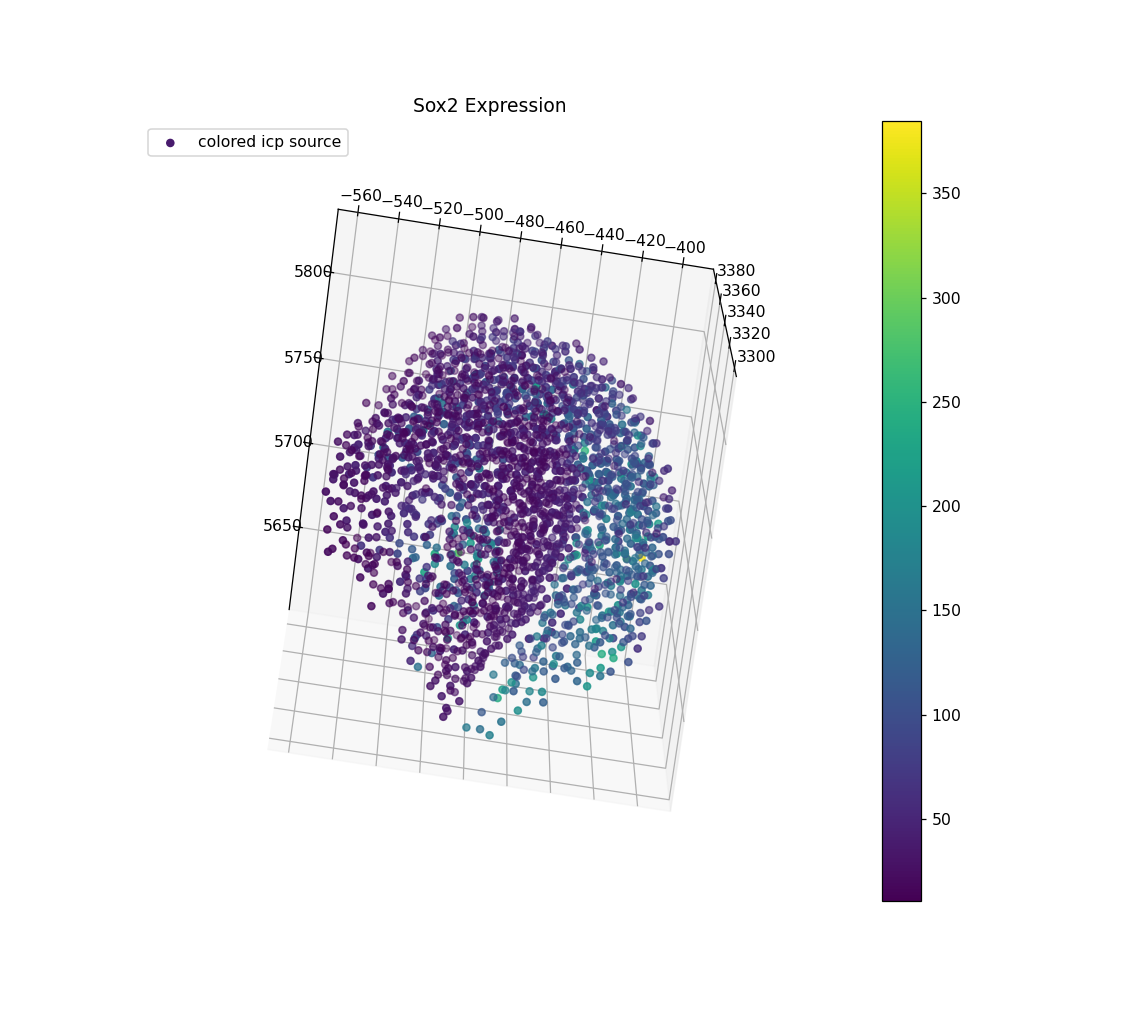

In [540]:
#plot points with colour

fig = plt.figure(figsize = (10,9))

source_ax = fig.add_subplot(111, projection='3d')
source_pts=np.asarray(source.points)
source_ax.scatter(xs = source_pts[:,0], ys = source_pts[:,1], zs = source_pts[:,2], color=source.colors,label = 'colored icp source')
source_ax.legend(loc='upper left')
source_ax.title.set_text('Sox2 Expression')
fig.colorbar(source_col_range)




In [552]:
source_aligned_coloredICP.points

std::vector<Eigen::Vector3d> with 2363 elements.
Use numpy.asarray() to access data.

<IPython.core.display.Javascript object>


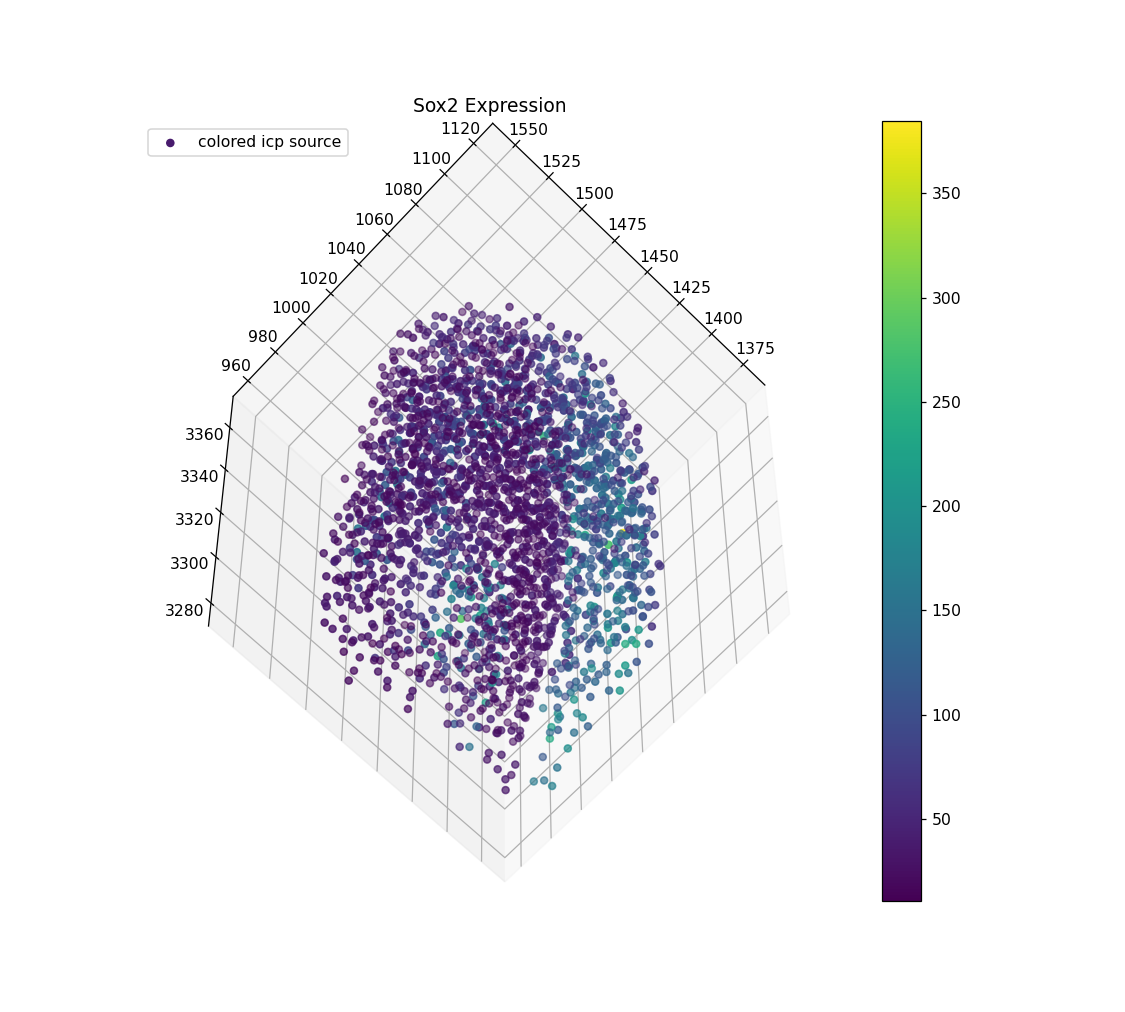

In [549]:
#plot points with colour
source_icp_points = np.asarray(source_aligned_coloredICP.points)
fig = plt.figure(figsize = (10,9))

source_ax = fig.add_subplot(111, projection='3d')
source_pts=np.asarray(source.points)
source_ax.scatter(xs = source_icp_points[:,0], ys = source_icp_points[:,1], zs = source_icp_points[:,2], color=source_aligned_coloredICP.colors,label = 'colored icp source')
source_ax.legend(loc='upper left')
source_ax.title.set_text('Sox2 Expression')
fig.colorbar(source_col_range)




## Check if colors are unchanged

In [566]:
np.all([np.asarray(source.colors), np.asarray(source_aligned_coloredICP.colors)])

True

## Check if coordinates have changed 

In [568]:
np.asarray(source_aligned_coloredICP.points)

array([[1472.88385241,  977.29033343, 3279.19121471],
       [1484.92105852,  962.46921161, 3282.13155932],
       [1496.83860575,  976.84073118, 3283.91109581],
       ...,
       [1498.65620391, 1045.19677925, 3365.00828413],
       [1495.93941193, 1055.75958203, 3368.23055204],
       [1476.67806175, 1077.85727187, 3362.07116575]])

In [567]:
np.asarray(source.points)

array([[5701.18994141, -534.80603027, 3299.10009766],
       [5704.31982422, -553.59197998, 3302.34008789],
       [5721.89013672, -547.09100342, 3303.20996094],
       ...,
       [5761.14990234, -487.00698853, 3381.32006836],
       [5764.22021484, -476.43399048, 3384.16992188],
       [5758.33984375, -447.80700684, 3377.60009766]])

## Check if fpfh calculation output is the same

In [581]:
# parameters to optimize
voxel_size=10 
downsampling= False #whether or not to down sample point cloud to voxels of size "voxel_size"
norm_radius_modifier=2 #multiply by voxel size to get search radius when estimating normals
norm_maxnn=30 #maximum nearest neighbours for normal estimation
fpfh_radius_modifier=5 #multiply by voxel_size to get search radius when calculating fpfh feature
fpfh_maxnn=100 # maximum nearest neighbours for fpfh feature calculation
ransac_dist_modifier=1.5 # multiply by voxel_size for RANSAC distance threshold 
ransac_edge_length=0.9 # edge length for RANSAC correspondance checker pruning step
icp_dist_modifier=1.5 # multiply by voxel_size for ICP distance threshold 

In [586]:
radius_feature = voxel_size * fpfh_radius_modifier

source_fpfh = o3d.registration.compute_fpfh_feature(
        source,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=fpfh_maxnn))

source_aligned_fpfh = o3d.registration.compute_fpfh_feature(
        source_aligned_coloredICP,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=fpfh_maxnn))

In [585]:
source_fpfh.data[10,:]

array([31.79392859, 18.3001078 , 36.10665762, ..., 42.883584  ,
       45.5462024 , 18.22035574])

In [588]:
source_aligned_fpfh.data[10,:]

array([31.79392859, 18.3001078 , 36.10665762, ..., 42.883584  ,
       45.5462024 , 18.22035574])

In [589]:
np.all([source_fpfh.data, source_aligned_fpfh.data])

True

# Dealing with mapping issues in correspondence map

1. Some source points will be mapped to the same target point.
2. Some target points will have no corresponding source point.


In [676]:
source_indices = np.array(result_icp_colored.correspondence_set)[:,0]
target_indices = np.array(result_icp_colored.correspondence_set)[:,1]
repeated_target_indices = (set([x for x in target_indices if list(target_indices).count(x) > 1]))
unique_target_indices = [x for x in target_indices if x not in repeated_target_indices]

[635,
 1036,
 985,
 684,
 258,
 462,
 529,
 525,
 464,
 459,
 530,
 533,
 531,
 599,
 590,
 596,
 592,
 640,
 595,
 1003,
 597,
 600,
 1012,
 651,
 949,
 609,
 705,
 663,
 655,
 1021,
 656,
 1059,
 1026,
 659,
 963,
 1430,
 1429,
 1776,
 1002,
 1046,
 1001,
 1390,
 1000,
 1062,
 1087,
 1397,
 1426,
 1428,
 1162,
 1113,
 1157,
 1194,
 1122,
 1486,
 1487,
 1520,
 1521,
 1452,
 732,
 1095,
 1438,
 1108,
 1140,
 1101,
 1131,
 1109,
 1439,
 1099,
 1103,
 1139,
 1443,
 1463,
 1505,
 1184,
 1222,
 1183,
 1474,
 1509,
 1145,
 1446,
 1477,
 1822,
 1237,
 1234,
 1480,
 1482,
 1192,
 1751,
 2017,
 1705,
 2071,
 1695,
 1703,
 1706,
 1702,
 2020,
 1696,
 1412,
 1775,
 1431,
 1710,
 1759,
 1711,
 1772,
 2025,
 1750,
 1761,
 1773,
 2078,
 1716,
 2083,
 2081,
 1757,
 1760,
 1677,
 1353,
 1389,
 1354,
 1396,
 1357,
 1685,
 1737,
 1690,
 1736,
 1738,
 1765,
 1400,
 1764,
 1735,
 1767,
 2094,
 1741,
 2053,
 2051,
 1769,
 1774,
 1777,
 1432,
 1798,
 1876,
 1833,
 1832,
 1835,
 1836,
 1809,
 1779,
 1784,
 

In [682]:
len(unique_target_indices) + len(repeated_target_indices) + len(unmapped_targets) == np.array(target.points).shape[0]

True

In [624]:
target_repeats = {i:list(target_indices).count(i) for i in target_indices if list(target_indices).count(i) > 1}


In [625]:
target_repeats

{627: 3,
 1038: 2,
 1083: 2,
 1037: 2,
 588: 4,
 158: 2,
 527: 3,
 212: 3,
 257: 3,
 589: 2,
 636: 4,
 211: 2,
 526: 2,
 908: 2,
 950: 3,
 598: 2,
 261: 2,
 304: 2,
 648: 2,
 649: 3,
 262: 2,
 909: 2,
 953: 2,
 539: 2,
 959: 2,
 999: 2,
 267: 2,
 345: 4,
 344: 3,
 702: 4,
 657: 2,
 316: 2,
 699: 3,
 654: 2,
 701: 4,
 310: 2,
 1051: 2,
 708: 2,
 962: 2,
 1016: 2,
 1011: 2,
 1019: 3,
 1078: 4,
 1770: 2,
 1427: 3,
 1367: 2,
 1422: 2,
 1753: 2,
 1413: 3,
 1748: 2,
 1419: 4,
 997: 2,
 952: 2,
 1010: 2,
 1393: 3,
 1057: 2,
 1391: 2,
 1405: 2,
 1088: 2,
 1106: 2,
 1165: 2,
 1200: 2,
 1484: 2,
 1199: 2,
 1206: 3,
 1130: 2,
 1512: 3,
 1187: 2,
 1513: 2,
 1551: 2,
 1515: 3,
 1746: 2,
 1752: 2,
 1704: 2,
 1747: 2,
 1691: 2,
 1745: 2,
 1739: 2,
 1646: 2,
 1973: 2,
 2070: 2,
 2080: 2,
 2101: 2,
 2099: 3,
 2079: 2,
 2089: 3,
 1762: 3,
 1394: 2,
 1681: 3,
 1688: 3,
 1740: 2,
 1743: 2,
 1491: 2,
 1834: 2,
 1464: 2,
 1936: 2,
 2493: 2,
 2222: 2,
 2289: 2,
 2284: 3,
 2531: 2,
 2538: 2,
 2580: 2,
 2578: 

Create a function that takes a target point cloud, source point cloud, mapping result, gene intensity values:

Duplicate the target point cloud and remove the colors.
Create a dummy list with default value of zeros np.zero (To those points that are in the unmapped targets list, assign a color intensity value of 0.)
Next, we deal with points that have values mapped to them.
To those points that are repeated, we assign it a color value following this protocol:

for index in target_repeats:
    obtain the color intensity values of the source_points that are mapped to this (left column) -> obtian a list of numbers
    Output the intensity value -> give a value
    Assign value to correspon
    ding index of target point cloud 
   
To the remaining points, assign them the intensity value of the source cloud point with the correct index.

All points in the target point cloud should have a color.
Convert the dummy list colors to RGB
Map the RGB colors to the target point cloud.
Output the target point cloud.

Plot this and visualise.




In [718]:
def mapping_sourcecol2target(target, source, registration_result, source_intensity, target_intensity, method = "median"):
    target_new = copy.deepcopy(target)
    target_range = np.arange(0, np.array(target.points).shape[0])
    
    corr_map = np.array(registration_result.correspondence_set)
    source_indices = corr_map[:,0]
    target_indices = corr_map[:,1]
    
    unmapped_targets =np.where(np.invert(np.in1d(target_range, target_indices)))[0]
    target_repeats = {i:list(target_indices).count(i) for i in target_indices if list(target_indices).count(i) > 1}
    unique_target_indices = [x for x in target_indices if x not in repeated_target_indices]

    print("--- Correspondence map properties --- ")
    print(f"{len(unmapped_targets)} unmapped targets.")
    print(f"{len(target_repeats)} targets that are mapped by multiple source points.")
    print(f"{len(unique_target_indices)} targets that are uniquely mapped by a single source point.")
    print(f"Totaling to {len(unmapped_targets) + len(target_repeats) + len(unique_target_indices)} target points,\
 where there are {len(target.points)} target points to start with.\n---------------------------------------") 
    
    color_list = np.zeros(shape=(target_intensity.shape))
    
    if method == "median" or method == "Median": 
        print("Using median averaging")
        for ind in target_repeats:
            bool_mask = target_indices == ind
            source_indices_repeat = source_indices[bool_mask]
            color_list[ind] = np.median(source_intensity[source_indices_repeat])

        for ind in unique_target_indices:
            bool_mask = target_indices == ind
            source_indices_unique = source_indices[bool_mask]
            color_list[ind] = source_intensity[source_indices_unique]
            
    elif method == "mean" or method == "Mean" or method == "average" or method == "Average":
        print("Using mean averaging")
        for ind in target_repeats:
            bool_mask = target_indices == ind
            source_indices_repeat = source_indices[bool_mask]
            color_list[ind] = np.mean(source_intensity[source_indices_repeat])

        for ind in unique_target_indices:
            bool_mask = target_indices == ind
            source_indices_unique = source_indices[bool_mask]
            color_list[ind] = source_intensity[source_indices_unique]
    else:
        raise Exception("Unrecognised method used. Only mean/average or median functions are permitted.") 
        
    #print("before assignment", np.array(target_new.colors))
    
    mapped_rgb, mapped_col_range=colour_map(color_list,"viridis")
    target_new.colors =o3d.utility.Vector3dVector(mapped_rgb)

    #print("after assignment", np.array(target_new.colors))
    #print(np.all([mapped_rgb, np.array(target_new.colors)]))
    
    return (target_new,mapped_col_range)

mapped_target, mapped_col_range = mapping_sourcecol2target(target, source, result_icp_colored, sox2_source, sox2_target, "median")

--- Correspondence map properties --- 
1191 unmapped targets.
548 targets that are mapped by multiple source points.
1139 targets that are uniquely mapped by a single source point.
Totaling to 2878 target points, where there are 2878 target points to start with.
---------------------------------------
Using median averaging


<IPython.core.display.Javascript object>


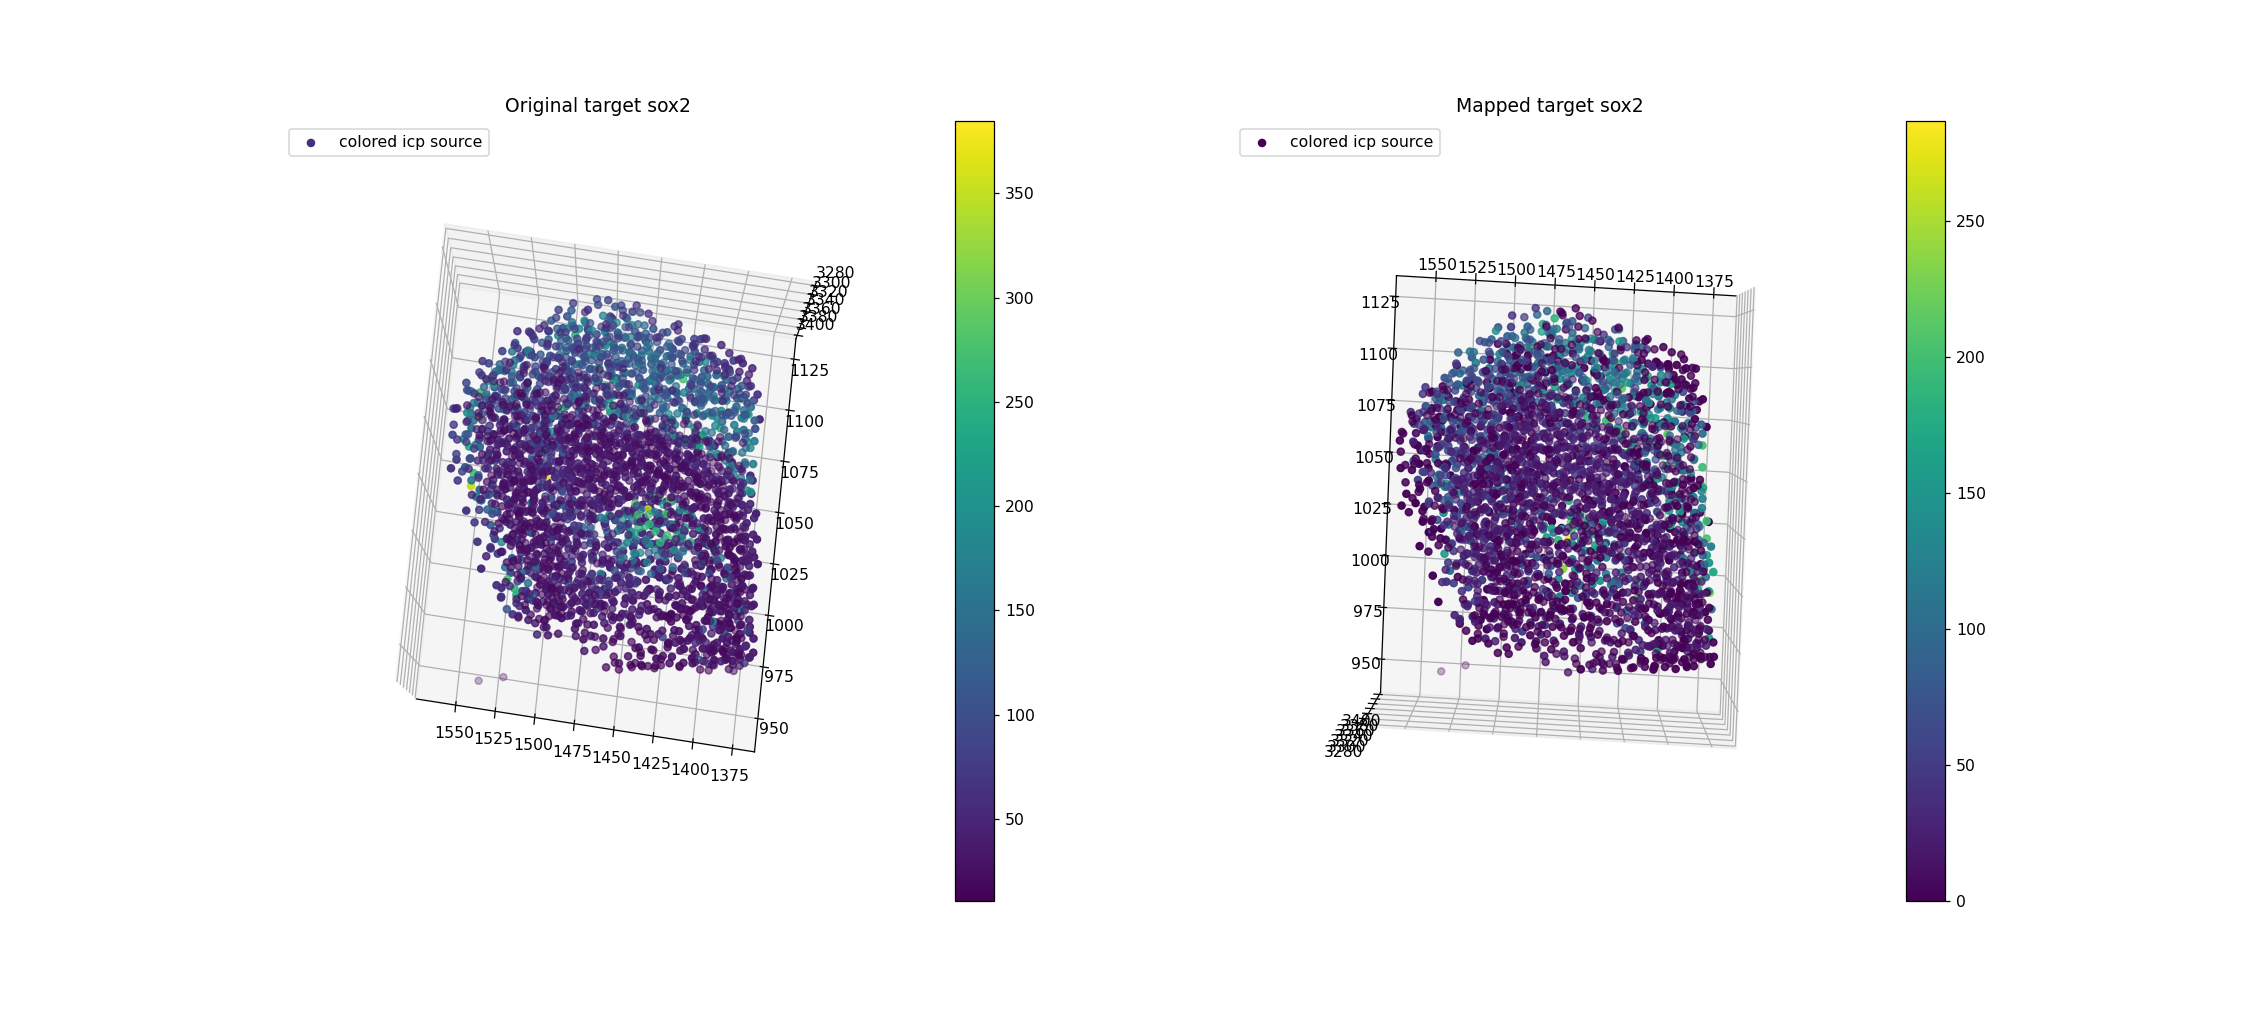

In [719]:
#plot points with colour

fig = plt.figure(figsize = (20,9))
target_ax = fig.add_subplot(121, projection='3d')

target_pts=np.asarray(target.points)
target_ax.scatter(xs = target_pts[:,0], ys = target_pts[:,1], zs = target_pts[:,2], color=target.colors,label = 'colored icp source')
target_ax.legend(loc='upper left')
target_ax.title.set_text('Original target sox2')
fig.colorbar(source_col_range)

mapped_ax = fig.add_subplot(122, projection='3d')

mapped_pts=np.asarray(mapped_target.points)
mapped_ax.scatter(xs = mapped_pts[:,0], ys = mapped_pts[:,1], zs = mapped_pts[:,2], color=mapped_target.colors,label = 'colored icp source')
mapped_ax.legend(loc='upper left')
mapped_ax.title.set_text('Mapped target sox2')
fig.colorbar(mapped_col_range)





In [ ]:
len(source_indices) + len(outlier_indices) ==  len(source.points)

In [671]:
color_list = np.zeros(shape=(sox2_target.shape))
my_ind = np.array(result_icp_colored.correspondence_set)[:,1] == 627
source_indices_repeat = np.array(result_icp_colored.correspondence_set)[:,0][my_ind]
np.median(sox2_source[source_indices_repeat])
color_list[627] = np.median(sox2_source[source_indices_repeat])
color_list[627]

#sox2_source[source_indices_repeat]

array([122.343])

In [683]:
for ind in target_repeats:
    print(ind)

627
1038
1083
1037
588
158
527
212
257
589
636
211
526
908
950
598
261
304
648
649
262
909
953
539
959
999
267
345
344
702
657
316
699
654
701
310
1051
708
962
1016
1011
1019
1078
1770
1427
1367
1422
1753
1413
1748
1419
997
952
1010
1393
1057
1391
1405
1088
1106
1165
1200
1484
1199
1206
1130
1512
1187
1513
1551
1515
1746
1752
1704
1747
1691
1745
1739
1646
1973
2070
2080
2101
2099
2079
2089
1762
1394
1681
1688
1740
1743
1491
1834
1464
1936
2493
2222
2289
2284
2531
2538
2580
2578
2581
2341
2543
2717
2722
2387
2599
2381
2382
2388
2479
2657
2663
2518
2661
2703
2697
2622
2461
2422
2162
2182
2187
1899
2237
2233
2236
2466
2495
2470
2239
2299
2253
2296
2553
2240
2545
2590
2550
2724
2596
2320
2563
2597
2725
2736
2324
2602
1516
1227
1193
1873
1557
1612
1859
1912
1555
1959
1614
1961
1621
1960
1947
1962
1672
725
767
1125
1124
1127
1175
1213
1493
1529
1214
1174
1177
1180
1496
2459
2652
2499
2546
2686
2693
2719
2689
2818
2685
2727
2817
2721
2734
2732
2758
2733
2730
2833
2713
2675
2812
2831
2681
2861

In [647]:
target_repeats

{627: 3,
 1038: 2,
 1083: 2,
 1037: 2,
 588: 4,
 158: 2,
 527: 3,
 212: 3,
 257: 3,
 589: 2,
 636: 4,
 211: 2,
 526: 2,
 908: 2,
 950: 3,
 598: 2,
 261: 2,
 304: 2,
 648: 2,
 649: 3,
 262: 2,
 909: 2,
 953: 2,
 539: 2,
 959: 2,
 999: 2,
 267: 2,
 345: 4,
 344: 3,
 702: 4,
 657: 2,
 316: 2,
 699: 3,
 654: 2,
 701: 4,
 310: 2,
 1051: 2,
 708: 2,
 962: 2,
 1016: 2,
 1011: 2,
 1019: 3,
 1078: 4,
 1770: 2,
 1427: 3,
 1367: 2,
 1422: 2,
 1753: 2,
 1413: 3,
 1748: 2,
 1419: 4,
 997: 2,
 952: 2,
 1010: 2,
 1393: 3,
 1057: 2,
 1391: 2,
 1405: 2,
 1088: 2,
 1106: 2,
 1165: 2,
 1200: 2,
 1484: 2,
 1199: 2,
 1206: 3,
 1130: 2,
 1512: 3,
 1187: 2,
 1513: 2,
 1551: 2,
 1515: 3,
 1746: 2,
 1752: 2,
 1704: 2,
 1747: 2,
 1691: 2,
 1745: 2,
 1739: 2,
 1646: 2,
 1973: 2,
 2070: 2,
 2080: 2,
 2101: 2,
 2099: 3,
 2079: 2,
 2089: 3,
 1762: 3,
 1394: 2,
 1681: 3,
 1688: 3,
 1740: 2,
 1743: 2,
 1491: 2,
 1834: 2,
 1464: 2,
 1936: 2,
 2493: 2,
 2222: 2,
 2289: 2,
 2284: 3,
 2531: 2,
 2538: 2,
 2580: 2,
 2578: 

## % of unmapped target points

In [636]:
len(unmapped_targets)/len(target.points)*100

41.38290479499653

In [614]:
len(target_indices)

2349

In [616]:
source.points

std::vector<Eigen::Vector3d> with 2363 elements.
Use numpy.asarray() to access data.

In [603]:
source_aligned_coloredICP.points

std::vector<Eigen::Vector3d> with 2363 elements.
Use numpy.asarray() to access data.

In [604]:
target.points

std::vector<Eigen::Vector3d> with 2878 elements.
Use numpy.asarray() to access data.

In [593]:
l = [1,2,3,4,4,5,5,6,1]
set([x for x in l if l.count(x) > 1])

{1, 4, 5}